# PROJET 7 : IMPLEMENTER UN MODELE DE SCORING

# SOMMAIRE

## IMPORTATIONS ET FONCTIONS
## DONNEES
## MATRICE DE CORRELATION
## EQUILIBRAGE ET STANDARDISATION
## CUSTOM METRIQUE
## CHOIX CLASSIFIER
## OPTIMISATION BAYESIENNE
## MODELISATION LGBM
## COURBE ROC-AUC ET MATRICE DE CONFUSION
## FEATURES IMPORTANCE
## ADAPTATION DASHBOARD

## IMPORTATIONS ET FONCTIONS

In [77]:
import requests
import numpy as np
from lime import lime_tabular
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump, load
import random
from timeit import default_timer as timer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import streamlit as st
import joblib
import math

%matplotlib inline

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Model
import lightgbm as lgb
from lightgbm.sklearn import LGBMClassifier
from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score, make_scorer
from sklearn.metrics import average_precision_score, log_loss, accuracy_score, classification_report, recall_score, precision_score
from sklearn.pipeline import Pipeline as pipe
from bayes_opt import BayesianOptimization
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from P7_01_functions import *
import shap

# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:,.2f}'.format

MAX_EVALS = 500
N_FOLDS = 10

global weight_f1
weight_f1 = 1.6

In [2]:
def reverse_one_hot_encoding(df):
    status_list = df.to_numpy().argsort()[:,-1]
    temp_list = []
    for idx, x in np.ndenumerate(status_list):
        temp_list.append(df.columns[x])
    
    return temp_list

def anciennete(d) :
    
    if math.isnan(d) :
        return str(np.nan)
    else:
        d = abs(d)
        year = int(np.floor(np.divide(d, 365)))
        month = np.round(np.multiply(np.divide(np.divide(d, 30),12) - year, 12),2)
        day = int(np.multiply(month - np.floor(month), 30))
        month = int(np.floor(month))
        anciennete = str(year) + "a  " + str(month) + "m  " + str(day) + "j"

        return anciennete

def import_data_binary(source = "applications_traintest_feather"):
    raw_data = pd.read_feather(source)
    column = raw_data.columns.str.replace('/', '_')
    column = column.str.replace('-', '_')
    column = column.str.replace(',', '_')
    raw_data.columns = column
    raw_data.set_index('SK_ID_CURR',inplace = True)
    raw_data = reduce_mem_usage(raw_data)
    return raw_data

## DONNEES

In [3]:
raw_data = import_data_binary()

Memory usage of dataframe is 103.62 MB
Memory usage after optimization is: 181.08 MB
Decreased by -74.8%


In [4]:
raw_data.shape

(356249, 139)

In [5]:
raw_data.TARGET.value_counts().divide(raw_data.TARGET.value_counts().sum())

0.00   0.92
1.00   0.08
Name: TARGET, dtype: float64

In [6]:
raw_data.isna().sum()

TARGET                                                48744
NAME_CONTRACT_TYPE                                        0
CODE_GENDER                                               0
FLAG_OWN_CAR                                              0
FLAG_OWN_REALTY                                           0
CNT_CHILDREN                                              0
AMT_INCOME_TOTAL                                          0
AMT_CREDIT                                                0
AMT_ANNUITY                                              36
AMT_GOODS_PRICE                                         276
REGION_POPULATION_RELATIVE                                0
DAYS_BIRTH                                                0
DAYS_EMPLOYED                                         64648
DAYS_REGISTRATION                                         0
DAYS_ID_PUBLISH                                           0
OWN_CAR_AGE                                          235237
CNT_FAM_MEMBERS                         

In [7]:
df_test = raw_data.drop(raw_data.dropna(subset=['TARGET']).index)
df_train = raw_data.dropna(subset=['TARGET'])
del raw_data

In [8]:
df_train.isna().sum()

TARGET                                                    0
NAME_CONTRACT_TYPE                                        0
CODE_GENDER                                               0
FLAG_OWN_CAR                                              0
FLAG_OWN_REALTY                                           0
CNT_CHILDREN                                              0
AMT_INCOME_TOTAL                                          0
AMT_CREDIT                                                0
AMT_ANNUITY                                              12
AMT_GOODS_PRICE                                         276
REGION_POPULATION_RELATIVE                                0
DAYS_BIRTH                                                0
DAYS_EMPLOYED                                         55374
DAYS_REGISTRATION                                         0
DAYS_ID_PUBLISH                                           0
OWN_CAR_AGE                                          202925
CNT_FAM_MEMBERS                         

In [9]:
df_train.shape

(307505, 139)

In [10]:
mask_categ = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Rare',
 'NAME_TYPE_SUITE_Spouse_ partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Rare',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary _ secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single _ not married',
 'NAME_FAMILY_STATUS_Unknown',
 'NAME_FAMILY_STATUS_Widow',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low_skill Laborers',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Realty agents',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Secretaries',
 'ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Business Entity',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Education',
 'ORGANIZATION_TYPE_Finance',
 'ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_HotelRestaurant',
 'ORGANIZATION_TYPE_House',
 'ORGANIZATION_TYPE_Industry',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_Public',
 'ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Self_employed',
 'ORGANIZATION_TYPE_Services',
 'ORGANIZATION_TYPE_Trade',
 'ORGANIZATION_TYPE_Transport',
 'ORGANIZATION_TYPE_XNA']

In [11]:
mask_categ = df_train.drop(mask_categ, axis = 1).columns

## MATRICE DE CORRELATION

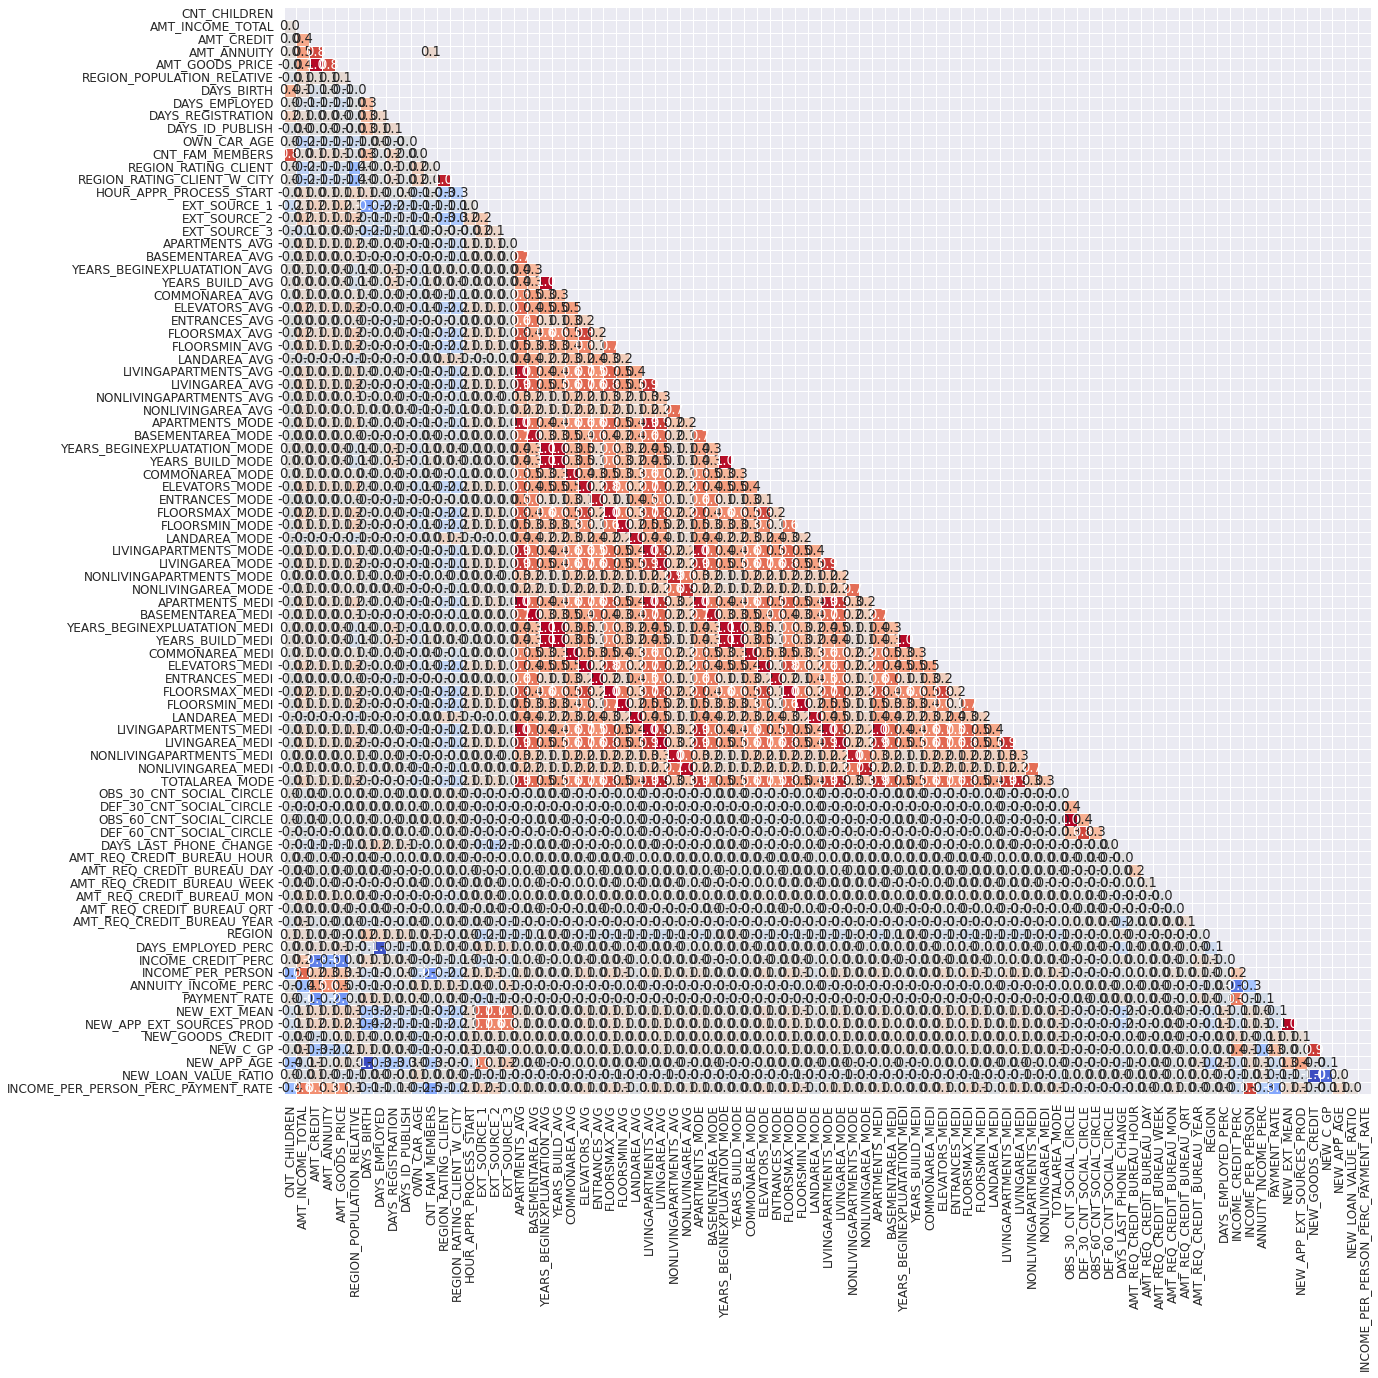

In [12]:
# Correlation
corr_plot(df_train[mask_categ], remove=['TARGET'], corr_coef = "spearman")

In [13]:
high_correlation(df_train[mask_categ], remove=['TARGET'], corr_coef = "spearman", corr_value = 0.90)

AMT_CREDIT
-------------------------------
AMT_GOODS_PRICE   0.98
Name: AMT_CREDIT, dtype: float64


AMT_GOODS_PRICE
-------------------------------
AMT_CREDIT   0.98
Name: AMT_GOODS_PRICE, dtype: float64


DAYS_BIRTH
-------------------------------
NEW_APP_AGE   -1.00
Name: DAYS_BIRTH, dtype: float64


DAYS_EMPLOYED
-------------------------------
DAYS_EMPLOYED_PERC   -0.97
Name: DAYS_EMPLOYED, dtype: float64


REGION_RATING_CLIENT
-------------------------------
REGION_RATING_CLIENT_W_CITY   0.95
Name: REGION_RATING_CLIENT, dtype: float64


REGION_RATING_CLIENT_W_CITY
-------------------------------
REGION_RATING_CLIENT   0.95
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64


APARTMENTS_AVG
-------------------------------
APARTMENTS_MEDI         1.00
LIVINGAPARTMENTS_AVG    0.97
LIVINGAPARTMENTS_MEDI   0.97
APARTMENTS_MODE         0.96
LIVINGAPARTMENTS_MODE   0.94
LIVINGAREA_AVG          0.91
LIVINGAREA_MEDI         0.90
Name: APARTMENTS_AVG, dtype: float64


BASEMENTAREA_AVG
-----

**Suite aux correlations trouvées, nous éliminons toutes les corrélation au-dessus de 0.95 et en-dessous de -0.95**

In [12]:
col_corr = ['AMT_GOODS_PRICE', 'NEW_APP_AGE', 'DAYS_EMPLOYED_PERC', 'REGION_RATING_CLIENT_W_CITY',
            'APARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'APARTMENTS_MODE',
            'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_AVG',
            'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MEDI',
            'COMMONAREA_MODE', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ENTRANCES_MEDI', 'ENTRANCES_MODE',
            'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'LANDAREA_MEDI', 'LANDAREA_MODE', 'NONLIVINGAPARTMENTS_MEDI',
            'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
            'NEW_APP_EXT_SOURCES_PROD', 'NEW_LOAN_VALUE_RATIO', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

## EQUILIBRAGE ET STANDARDISATION

In [13]:
mask_categ

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG',
       'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
       'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG',
       'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
 

In [14]:
mask_categ = list(mask_categ)

for i in col_corr :
    if i in mask_categ:
        mask_categ.remove(i)
    

In [15]:
df_train = df_train.drop(col_corr, axis = 1)

In [16]:
df_train.describe()

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
count 307,505.00          307,505.00   307,505.00    307,505.00   
mean        0.08                0.10         0.66          0.34   
std         0.27                0.29         0.47          0.47   
min         0.00                0.00         0.00          0.00   
25%         0.00                0.00         0.00          0.00   
50%         0.00                0.00         1.00          0.00   
75%         0.00                0.00         1.00          1.00   
max         1.00                1.00         1.00          1.00   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL   AMT_CREDIT  \
count       307,505.00    307,505.00        307,505.00   307,505.00   
mean              0.31          0.42        168,737.84   598,833.19   
std               0.46          0.72        237,177.64   402,473.69   
min               0.00          0.00         25,650.00    45,000.00   
25%               0.00          0.00        112,500.00   270,000.00   
50%               0.00          0.00        147,150.00   513,531.00   
75%               1.00          1.00        202,500.00   808,650.00   
max               1.00         19.00    117,000,000.00 4,050,000.00   

       AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
count   307,493.00                  307,505.00  307,505.00     252,131.00   
mean     27,111.02                        0.02  -16,037.05      -2,384.15   
std      14,493.32                        0.01    4,363.99       2,338.26   
min       1,615.50                        0.00  -25,229.00     -17,912.00   
25%      16,524.00                        0.01  -19,682.00      -3,175.00   
50%      24,903.00                        0.02  -15,750.00      -1,648.00   
75%      34,596.00                        0.03  -12,413.00        -767.00   
max     258,025.50                        0.07   -7,489.00           0.00   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
count         307,505.00       307,505.00   104,580.00       307,505.00   
mean           -4,986.06        -2,994.20        12.06             2.15   
std             3,522.75         1,509.45        11.94             0.91   
min           -24,672.00        -7,197.00         0.00             1.00   
25%            -7,480.00        -4,299.00         5.00             2.00   
50%            -4,504.00        -3,254.00         9.00             2.00   
75%            -2,010.00        -1,720.00        15.00             3.00   
max                 0.00             0.00        91.00            20.00   

       REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  APARTMENTS_AVG  \
count            307,505.00               307,505.00      151,446.00   
mean                   2.05                    12.06            0.12   
std                    0.51                     3.27            0.11   
min                    1.00                     0.00            0.00   
25%                    2.00                    10.00            0.06   
50%                    2.00                    12.00            0.09   
75%                    2.00                    14.00            0.15   
max                    3.00                    23.00            1.00   

       BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  COMMONAREA_AVG  \
count        127,564.00                   157,500.00       92,644.00   
mean               0.09                         0.98            0.04   
std                0.08                         0.06            0.08   
min                0.00                         0.00            0.00   
25%                0.04                         0.98            0.01   
50%                0.08                         0.98            0.02   
75%                0.11                         0.99            0.05   
max                1.00                         1.00            1.00   

       ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
count     143,616.00     152,

In [17]:
df_train.dropna(subset = ['TARGET'], inplace=True)

In [18]:
x = df_train.drop('TARGET', axis=1)
y = df_train.TARGET


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

**Pour rééquilibrer les classes nous allons utiliser la méthode de l'undersampling en nous bassant sur la classes la plus faible, nous allons diminuer la classe la plus importante.**

**Après split en jeu d'entraînement et jeu de test, nous standardisons les données**

In [19]:
scaler_x = StandardScaler()

over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

x_reduced, y_reduced = over.fit_resample(x_train, y_train)
x_reduced, y_reduced = under.fit_resample(x_reduced, y_reduced)

x_reduced[mask_categ] = scaler_x.fit_transform(x_reduced[mask_categ])
x_train[mask_categ] = scaler_x.transform(x_train[mask_categ])
x_test[mask_categ] = scaler_x.transform(x_test[mask_categ])

## CUSTOM METRIQUE

**Dans le contexte du projet nous devons trouver un métrique qui favorise la classe non-solvable, nous définissons donc un métrique personnalisé pour rajouter un coefficient qui donner un poids plus important à cette classe**

In [20]:
def evaluate_macroF1_lgb(predictions, truth):
    truth = truth.get_label()
    
    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    
    recall = TP / (TP + FN)

    precision = TP / (TP + FP)

    F1 = (weight_f1+1)/(weight_f1/recall + 1/precision)
    
    if np.isnan(F1) :
        F1 = 0
    
    print(F1)
    return ('F1_weighted', F1, True) 

def evaluate_macroF1_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((precision*recall)/(precision*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_roc_auc_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((specificity*recall)/(specificity*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_roc_aucdirect_lgb(truth, predictions):

    mask = truth ==1
    pred_labels = predictions
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((specificity*recall)/(specificity*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_macroF1bis_lgb_cv(truth, predictions):

    mask = truth ==1
    pred_labels = np.where(predictions < 0.5, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((precision*recall)/(precision*(weight_f1**2)+recall))
    
    return (F1)

def evaluate_macroF1direct_lgb(truth, predictions):

    mask = truth ==1
    pred_labels = predictions
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    specificity = TN / (TN + FP)
    
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    F1 = ((weight_f1**2)+1)*((precision*recall)/(precision*(weight_f1**2)+recall))
    
    return (F1)

## CHOIX CLASSIFIER

In [23]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [25]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = params, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True), n_iter = 30, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
xgb_random.fit(x_reduced, y_reduced)

pred_test = xgb_random.predict(x_test)
pred_train = xgb_random.predict(x_train)

TN, FP, FN, TP = confusion_matrix(y_train, pred_train).ravel()
specificity_train = TN / (TN + FP)
TN, FP, FN, TP = confusion_matrix(y_test, pred_test).ravel()
specificity_test = TN / (TN + FP)

print("F1 score : " + str(xgb_random.best_score_),
     "\n-------------------\n",
     "Recall score train : " + str(recall_score(y_train, pred_train)), "\n",
     "Recall score test : " + str(recall_score(y_test, pred_test)), "\n",
     "-------------------\n",
     "Specificity score train : " + str(specificity_train) + "\n",
     "Specificity score test : " + str(specificity_test) + "\n")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[11:37:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:37:40] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
F1 score : 0.4692239816317917 
-------------------
 Recall score train : 0.46168190567853706 
 Recall score test : 0.42165589562248507 
 -------------------
 Specificity score train : 0.8849179531583282
 Specificity score test : 0.8815450919850766



In [27]:
params = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 5, 10],
        'reg_alpha': [0, 0.1, 0.2, 0.4, 0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [28]:
lgbm = LGBMClassifier(metric="custom")
lgbm_random = RandomizedSearchCV(estimator = lgbm, param_distributions = params, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True), n_iter = 30, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
lgbm_random.fit(x_reduced, y_reduced)

pred_test = lgbm_random.predict(x_test)
pred_train = lgbm_random.predict(x_train)

TN, FP, FN, TP = confusion_matrix(y_train, pred_train).ravel()
specificity_train = TN / (TN + FP)
TN, FP, FN, TP = confusion_matrix(y_test, pred_test).ravel()
specificity_test = TN / (TN + FP)

print("F1 score : " + str(lgbm_random.best_score_),
     "\n-------------------\n",
     "Recall score train : " + str(recall_score(y_train, pred_train)), "\n",
     "Recall score test : " + str(recall_score(y_test, pred_test)), "\n",
     "-------------------\n",
     "Specificity score train : " + str(specificity_train) + "\n",
     "Specificity score test : " + str(specificity_test) + "\n")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
F1 score : 0.49104570531679903 
-------------------
 Recall score train : 0.5299566891241578 
 Recall score test : 0.43006950371905867 
 -------------------
 Specificity score train : 0.8767132689911512
 Specificity score test : 0.8689266263561902



## OPTIMISATION BAYESIENNE

**Avec l'optimisation Bayesienne nous définissons des espaces de recherche pour l'optimisation de nos hyper-paramètres**

In [43]:


def hyperopt_train_test(params):
    X_ = x_train[:]
    if 'normalize' in params:
        if params['normalize'] == 1:
            X_ = normalize(X_)
            del params['normalize']
    if 'scale' in params:
        if params['scale'] == 1:
            X_ = scale(X_)
            del params['scale']
    return cross_val_score(LGBMClassifier(**params), x_reduced, y_reduced, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True)).mean()
space4rf = {
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'colsample_bytree': hp.choice('colsampleµ_bytree', np.around(np.linspace(0, 1, 20),3)),
            'learning_rate': hp.choice('learning_rate', np.around(np.linspace(0, 1, 30), 3)),
            'max_depth': hp.choice('max_depth', np.arange(1, 1000, 50)),
            'min_child_samples': hp.choice('min_child_samples', np.arange(1, 1000, 30)),
            'num_leaves': hp.choice('num_leaves', np.arange(1, 1000, 30)),
            'reg_alpha': hp.choice('reg_alpha', np.around(np.linspace(0, 1, 20),3)),
            'reg_lambda': hp.choice('reg_lambda', np.around(np.linspace(0, 1, 20), 3)),
            'subsample': hp.choice('subsample', np.around(np.linspace(0, 1, 30),3))
}
best = 0
def f(params):
    global best
    acc = hyperopt_train_test(params)
    if acc > best:
        best = acc
    print('new best:', best, params)
    return {'loss': -acc, 'status': STATUS_OK}
trials = Trials()
best = fmin(f, space4rf, algo=tpe.suggest, max_evals=300, trials=trials)
print('best: ' + str(best))

  0%|          | 0/300 [00:00<?, ?trial/s, best loss=?]

2022-03-18 22:55:48.555 INFO    hyperopt.tpe: build_posterior_wrapper took 0.005844 seconds
2022-03-18 22:55:48.555 INFO    hyperopt.tpe: TPE using 0 trials


new best:                                              
0.28593004328495947                                    
{'class_weight': None, 'colsample_bytree': 0.368, 'learning_rate': 0.828, 'max_depth': 501, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.895, 'reg_lambda': 0.684, 'subsample': 0.379}
  0%|          | 1/300 [00:06<31:09,  6.25s/trial, best loss: -0.28593004328495947]

2022-03-18 22:55:54.808 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007019 seconds
2022-03-18 22:55:54.808 INFO    hyperopt.tpe: TPE using 1/1 trials with best loss -0.285930


new best:                                                                          
0.35508846544263006                                                                
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.034, 'max_depth': 201, 'min_child_samples': 991, 'num_leaves': 991, 'reg_alpha': 0.737, 'reg_lambda': 0.368, 'subsample': 0.207}
  1%|          | 2/300 [00:09<23:38,  4.76s/trial, best loss: -0.35508846544263006]

2022-03-18 22:55:58.524 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006803 seconds
2022-03-18 22:55:58.525 INFO    hyperopt.tpe: TPE using 2/2 trials with best loss -0.355088


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.368, 'learning_rate': 0.345, 'max_depth': 1, 'min_child_samples': 871, 'num_leaves': 901, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.034}
  1%|          | 3/300 [00:12<19:22,  3.92s/trial, best loss: -0.3566145629424898] 

2022-03-18 22:56:01.434 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006621 seconds
2022-03-18 22:56:01.435 INFO    hyperopt.tpe: TPE using 3/3 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 601, 'min_child_samples': 931, 'num_leaves': 691, 'reg_alpha': 0.053, 'reg_lambda': 0.947, 'subsample': 0.034}
  1%|▏         | 4/300 [00:14<14:52,  3.01s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:03.070 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011622 seconds
2022-03-18 22:56:03.071 INFO    hyperopt.tpe: TPE using 3/4 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': 'balanced', 'colsample_bytree': 0.947, 'learning_rate': 0.966, 'max_depth': 151, 'min_child_samples': 1, 'num_leaves': 391, 'reg_alpha': 0.684, 'reg_lambda': 0.0, 'subsample': 0.034}
  2%|▏         | 5/300 [00:31<39:54,  8.12s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:20.227 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006894 seconds
2022-03-18 22:56:20.228 INFO    hyperopt.tpe: TPE using 4/5 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': None, 'colsample_bytree': 0.316, 'learning_rate': 0.724, 'max_depth': 801, 'min_child_samples': 991, 'num_leaves': 181, 'reg_alpha': 0.895, 'reg_lambda': 0.789, 'subsample': 0.931}
  2%|▏         | 6/300 [00:35<32:38,  6.66s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:24.070 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006729 seconds
2022-03-18 22:56:24.071 INFO    hyperopt.tpe: TPE using 5/6 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': None, 'colsample_bytree': 0.368, 'learning_rate': 0.793, 'max_depth': 451, 'min_child_samples': 811, 'num_leaves': 811, 'reg_alpha': 0.368, 'reg_lambda': 0.368, 'subsample': 0.483}
  2%|▏         | 7/300 [00:39<28:36,  5.86s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:28.271 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008250 seconds
2022-03-18 22:56:28.272 INFO    hyperopt.tpe: TPE using 6/7 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 451, 'min_child_samples': 181, 'num_leaves': 541, 'reg_alpha': 0.421, 'reg_lambda': 0.737, 'subsample': 0.759}
  3%|▎         | 8/300 [00:41<21:56,  4.51s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:29.895 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011886 seconds
2022-03-18 22:56:29.896 INFO    hyperopt.tpe: TPE using 6/8 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': None, 'colsample_bytree': 0.947, 'learning_rate': 0.828, 'max_depth': 951, 'min_child_samples': 181, 'num_leaves': 631, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.379}
  3%|▎         | 9/300 [00:51<30:38,  6.32s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:40.181 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006757 seconds
2022-03-18 22:56:40.182 INFO    hyperopt.tpe: TPE using 7/9 trials with best loss -0.356615


new best:                                                                         
0.3566145629424898                                                                
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.31, 'max_depth': 651, 'min_child_samples': 631, 'num_leaves': 91, 'reg_alpha': 0.105, 'reg_lambda': 0.158, 'subsample': 0.069}
  3%|▎         | 10/300 [00:56<28:48,  5.96s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:45.343 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007089 seconds
2022-03-18 22:56:45.344 INFO    hyperopt.tpe: TPE using 8/10 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.158, 'learning_rate': 0.276, 'max_depth': 401, 'min_child_samples': 211, 'num_leaves': 391, 'reg_alpha': 0.105, 'reg_lambda': 0.0, 'subsample': 0.69}
  4%|▎         | 11/300 [01:02<28:18,  5.88s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:51.033 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006652 seconds
2022-03-18 22:56:51.034 INFO    hyperopt.tpe: TPE using 9/11 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.158, 'learning_rate': 0.828, 'max_depth': 151, 'min_child_samples': 721, 'num_leaves': 331, 'reg_alpha': 0.737, 'reg_lambda': 0.211, 'subsample': 0.759}
  4%|▍         | 12/300 [01:06<25:13,  5.25s/trial, best loss: -0.3566145629424898]

2022-03-18 22:56:54.952 INFO    hyperopt.tpe: build_posterior_wrapper took 0.095813 seconds
2022-03-18 22:56:54.952 INFO    hyperopt.tpe: TPE using 10/12 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.579, 'learning_rate': 0.103, 'max_depth': 601, 'min_child_samples': 571, 'num_leaves': 721, 'reg_alpha': 0.421, 'reg_lambda': 0.158, 'subsample': 0.586}
  4%|▍         | 13/300 [01:11<25:31,  5.34s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:00.389 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006814 seconds
2022-03-18 22:57:00.390 INFO    hyperopt.tpe: TPE using 11/13 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.105, 'learning_rate': 0.172, 'max_depth': 501, 'min_child_samples': 211, 'num_leaves': 901, 'reg_alpha': 0.684, 'reg_lambda': 0.211, 'subsample': 0.966}
  5%|▍         | 14/300 [01:16<24:59,  5.24s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:05.416 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007380 seconds
2022-03-18 22:57:05.417 INFO    hyperopt.tpe: TPE using 12/14 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.448, 'max_depth': 851, 'min_child_samples': 811, 'num_leaves': 661, 'reg_alpha': 0.737, 'reg_lambda': 0.737, 'subsample': 0.379}
  5%|▌         | 15/300 [01:21<24:01,  5.06s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:10.039 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006696 seconds
2022-03-18 22:57:10.040 INFO    hyperopt.tpe: TPE using 13/15 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.368, 'learning_rate': 0.655, 'max_depth': 351, 'min_child_samples': 991, 'num_leaves': 781, 'reg_alpha': 0.684, 'reg_lambda': 0.579, 'subsample': 0.931}
  5%|▌         | 16/300 [01:25<22:27,  4.75s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:14.065 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010737 seconds
2022-03-18 22:57:14.066 INFO    hyperopt.tpe: TPE using 14/16 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.579, 'learning_rate': 0.793, 'max_depth': 751, 'min_child_samples': 961, 'num_leaves': 211, 'reg_alpha': 0.579, 'reg_lambda': 0.211, 'subsample': 0.517}
  6%|▌         | 17/300 [01:29<21:18,  4.52s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:18.047 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007751 seconds
2022-03-18 22:57:18.047 INFO    hyperopt.tpe: TPE using 15/17 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.421, 'learning_rate': 0.517, 'max_depth': 701, 'min_child_samples': 931, 'num_leaves': 481, 'reg_alpha': 0.263, 'reg_lambda': 1.0, 'subsample': 0.103}
  6%|▌         | 18/300 [01:34<21:27,  4.57s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:22.727 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007431 seconds
2022-03-18 22:57:22.727 INFO    hyperopt.tpe: TPE using 16/18 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.579, 'learning_rate': 0.103, 'max_depth': 101, 'min_child_samples': 931, 'num_leaves': 331, 'reg_alpha': 0.526, 'reg_lambda': 0.158, 'subsample': 0.414}
  6%|▋         | 19/300 [01:38<20:33,  4.39s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:26.709 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010104 seconds
2022-03-18 22:57:26.709 INFO    hyperopt.tpe: TPE using 17/19 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.632, 'learning_rate': 0.828, 'max_depth': 301, 'min_child_samples': 331, 'num_leaves': 211, 'reg_alpha': 0.526, 'reg_lambda': 0.316, 'subsample': 0.207}
  7%|▋         | 20/300 [01:43<21:56,  4.70s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:32.129 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006960 seconds
2022-03-18 22:57:32.130 INFO    hyperopt.tpe: TPE using 18/20 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': None, 'colsample_bytree': 0.368, 'learning_rate': 0.379, 'max_depth': 751, 'min_child_samples': 661, 'num_leaves': 181, 'reg_alpha': 0.632, 'reg_lambda': 0.474, 'subsample': 0.414}
  7%|▋         | 21/300 [01:48<21:46,  4.68s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:36.780 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010343 seconds
2022-03-18 22:57:36.780 INFO    hyperopt.tpe: TPE using 19/21 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.368, 'learning_rate': 0.448, 'max_depth': 51, 'min_child_samples': 991, 'num_leaves': 691, 'reg_alpha': 0.263, 'reg_lambda': 0.579, 'subsample': 0.931}
  7%|▋         | 22/300 [01:52<20:47,  4.49s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:40.804 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007531 seconds
2022-03-18 22:57:40.805 INFO    hyperopt.tpe: TPE using 20/22 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.034, 'max_depth': 1, 'min_child_samples': 511, 'num_leaves': 121, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.276}
  8%|▊         | 23/300 [01:55<18:26,  3.99s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:43.646 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008499 seconds
2022-03-18 22:57:43.647 INFO    hyperopt.tpe: TPE using 21/23 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.526, 'learning_rate': 0.345, 'max_depth': 251, 'min_child_samples': 121, 'num_leaves': 991, 'reg_alpha': 0.211, 'reg_lambda': 0.053, 'subsample': 0.172}
  8%|▊         | 24/300 [02:05<27:51,  6.06s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:54.510 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007147 seconds
2022-03-18 22:57:54.511 INFO    hyperopt.tpe: TPE using 22/24 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.345, 'max_depth': 201, 'min_child_samples': 871, 'num_leaves': 841, 'reg_alpha': 0.789, 'reg_lambda': 0.632, 'subsample': 0.034}
  8%|▊         | 25/300 [02:10<25:51,  5.64s/trial, best loss: -0.3566145629424898]

2022-03-18 22:57:59.198 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010820 seconds
2022-03-18 22:57:59.198 INFO    hyperopt.tpe: TPE using 23/25 trials with best loss -0.356615


new best:                                                                          
0.3566145629424898                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 1, 'min_child_samples': 901, 'num_leaves': 31, 'reg_alpha': 1.0, 'reg_lambda': 0.421, 'subsample': 0.655}
  9%|▊         | 26/300 [02:12<20:14,  4.43s/trial, best loss: -0.3566145629424898]

2022-03-18 22:58:00.806 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006730 seconds
2022-03-18 22:58:00.806 INFO    hyperopt.tpe: TPE using 23/26 trials with best loss -0.356615


new best:                                                                          
0.35813854957418945                                                                
{'class_weight': 'balanced', 'colsample_bytree': 0.737, 'learning_rate': 0.034, 'max_depth': 201, 'min_child_samples': 271, 'num_leaves': 31, 'reg_alpha': 0.158, 'reg_lambda': 0.947, 'subsample': 0.862}
  9%|▉         | 27/300 [02:16<20:00,  4.40s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:05.121 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007432 seconds
2022-03-18 22:58:05.122 INFO    hyperopt.tpe: TPE using 24/27 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.737, 'learning_rate': 0.897, 'max_depth': 551, 'min_child_samples': 271, 'num_leaves': 31, 'reg_alpha': 0.158, 'reg_lambda': 0.947, 'subsample': 0.862}
  9%|▉         | 28/300 [02:20<19:43,  4.35s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:09.359 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008766 seconds
2022-03-18 22:58:09.360 INFO    hyperopt.tpe: TPE using 25/28 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.263, 'learning_rate': 0.138, 'max_depth': 901, 'min_child_samples': 61, 'num_leaves': 511, 'reg_alpha': 0.474, 'reg_lambda': 0.263, 'subsample': 0.138}
 10%|▉         | 29/300 [02:35<33:47,  7.48s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:24.147 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011323 seconds
2022-03-18 22:58:24.148 INFO    hyperopt.tpe: TPE using 26/29 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.069, 'max_depth': 1, 'min_child_samples': 871, 'num_leaves': 151, 'reg_alpha': 0.947, 'reg_lambda': 0.526, 'subsample': 0.828}
 10%|█         | 30/300 [02:37<26:05,  5.80s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:26.012 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006898 seconds
2022-03-18 22:58:26.013 INFO    hyperopt.tpe: TPE using 26/30 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.684, 'learning_rate': 0.069, 'max_depth': 1, 'min_child_samples': 31, 'num_leaves': 301, 'reg_alpha': 0.053, 'reg_lambda': 0.842, 'subsample': 0.448}
 10%|█         | 31/300 [02:40<22:02,  4.92s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:28.870 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007041 seconds
2022-03-18 22:58:28.871 INFO    hyperopt.tpe: TPE using 27/31 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.053, 'learning_rate': 0.621, 'max_depth': 1, 'min_child_samples': 451, 'num_leaves': 151, 'reg_alpha': 0.0, 'reg_lambda': 0.421, 'subsample': 1.0}
 11%|█         | 32/300 [02:43<19:05,  4.27s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:31.646 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010003 seconds
2022-03-18 22:58:31.647 INFO    hyperopt.tpe: TPE using 28/32 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.842, 'learning_rate': 0.414, 'max_depth': 201, 'min_child_samples': 751, 'num_leaves': 961, 'reg_alpha': 0.947, 'reg_lambda': 0.895, 'subsample': 0.552}
 11%|█         | 33/300 [02:47<19:25,  4.37s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:36.227 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006945 seconds
2022-03-18 22:58:36.228 INFO    hyperopt.tpe: TPE using 29/33 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.737, 'learning_rate': 0.483, 'max_depth': 701, 'min_child_samples': 691, 'num_leaves': 871, 'reg_alpha': 0.842, 'reg_lambda': 0.526, 'subsample': 0.0}
 11%|█▏        | 34/300 [02:49<15:41,  3.54s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:37.841 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006765 seconds
2022-03-18 22:58:37.841 INFO    hyperopt.tpe: TPE using 29/34 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.737, 'learning_rate': 0.862, 'max_depth': 951, 'min_child_samples': 91, 'num_leaves': 271, 'reg_alpha': 1.0, 'reg_lambda': 0.105, 'subsample': 0.862}
 12%|█▏        | 35/300 [02:57<21:38,  4.90s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:45.913 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006872 seconds
2022-03-18 22:58:45.914 INFO    hyperopt.tpe: TPE using 30/35 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.789, 'learning_rate': 0.759, 'max_depth': 601, 'min_child_samples': 391, 'num_leaves': 901, 'reg_alpha': 0.842, 'reg_lambda': 0.526, 'subsample': 0.0}
 12%|█▏        | 36/300 [02:58<17:13,  3.91s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:47.524 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006975 seconds
2022-03-18 22:58:47.525 INFO    hyperopt.tpe: TPE using 30/36 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.789, 'learning_rate': 0.931, 'max_depth': 201, 'min_child_samples': 391, 'num_leaves': 601, 'reg_alpha': 0.842, 'reg_lambda': 0.947, 'subsample': 0.724}
 12%|█▏        | 37/300 [03:04<19:39,  4.48s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:53.341 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007246 seconds
2022-03-18 22:58:53.342 INFO    hyperopt.tpe: TPE using 31/37 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.483, 'max_depth': 551, 'min_child_samples': 691, 'num_leaves': 61, 'reg_alpha': 0.158, 'reg_lambda': 0.526, 'subsample': 0.793}
 13%|█▎        | 38/300 [03:06<15:49,  3.63s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:54.964 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007309 seconds
2022-03-18 22:58:54.965 INFO    hyperopt.tpe: TPE using 31/38 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 701, 'min_child_samples': 871, 'num_leaves': 901, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.31}
 13%|█▎        | 39/300 [03:08<13:08,  3.02s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:56.574 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008318 seconds
2022-03-18 22:58:56.575 INFO    hyperopt.tpe: TPE using 31/39 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 1.0, 'max_depth': 601, 'min_child_samples': 271, 'num_leaves': 241, 'reg_alpha': 0.158, 'reg_lambda': 0.526, 'subsample': 0.655}
 13%|█▎        | 40/300 [03:09<11:18,  2.61s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:58.219 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008747 seconds
2022-03-18 22:58:58.220 INFO    hyperopt.tpe: TPE using 31/40 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 451, 'min_child_samples': 421, 'num_leaves': 931, 'reg_alpha': 0.158, 'reg_lambda': 0.526, 'subsample': 0.793}
 14%|█▎        | 41/300 [03:11<10:10,  2.36s/trial, best loss: -0.35813854957418945]

2022-03-18 22:58:59.995 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011636 seconds
2022-03-18 22:58:59.996 INFO    hyperopt.tpe: TPE using 31/41 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 901, 'min_child_samples': 541, 'num_leaves': 451, 'reg_alpha': 0.158, 'reg_lambda': 0.947, 'subsample': 0.0}
 14%|█▍        | 42/300 [03:13<09:22,  2.18s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:01.763 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007972 seconds
2022-03-18 22:59:01.764 INFO    hyperopt.tpe: TPE using 31/42 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 551, 'min_child_samples': 601, 'num_leaves': 931, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.621}
 14%|█▍        | 43/300 [03:14<08:49,  2.06s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:03.544 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008280 seconds
2022-03-18 22:59:03.544 INFO    hyperopt.tpe: TPE using 31/43 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.586, 'max_depth': 101, 'min_child_samples': 841, 'num_leaves': 901, 'reg_alpha': 0.316, 'reg_lambda': 0.526, 'subsample': 0.0}
 15%|█▍        | 44/300 [03:16<08:34,  2.01s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:05.427 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006662 seconds
2022-03-18 22:59:05.428 INFO    hyperopt.tpe: TPE using 31/44 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 301, 'min_child_samples': 901, 'num_leaves': 931, 'reg_alpha': 0.158, 'reg_lambda': 0.684, 'subsample': 0.897}
 15%|█▌        | 45/300 [03:18<08:14,  1.94s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:07.207 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006560 seconds
2022-03-18 22:59:07.208 INFO    hyperopt.tpe: TPE using 31/45 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 551, 'min_child_samples': 871, 'num_leaves': 241, 'reg_alpha': 0.158, 'reg_lambda': 0.526, 'subsample': 0.345}
 15%|█▌        | 46/300 [03:20<07:55,  1.87s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:08.921 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006838 seconds
2022-03-18 22:59:08.922 INFO    hyperopt.tpe: TPE using 31/46 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 351, 'min_child_samples': 151, 'num_leaves': 451, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.897}
 16%|█▌        | 47/300 [03:22<07:51,  1.86s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:10.769 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007121 seconds
2022-03-18 22:59:10.769 INFO    hyperopt.tpe: TPE using 31/47 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.737, 'learning_rate': 1.0, 'max_depth': 101, 'min_child_samples': 841, 'num_leaves': 871, 'reg_alpha': 0.158, 'reg_lambda': 0.526, 'subsample': 0.828}
 16%|█▌        | 48/300 [03:26<11:10,  2.66s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:15.290 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007689 seconds
2022-03-18 22:59:15.291 INFO    hyperopt.tpe: TPE using 32/48 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 701, 'min_child_samples': 691, 'num_leaves': 931, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.345}
 16%|█▋        | 49/300 [03:28<09:56,  2.38s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:17.007 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007065 seconds
2022-03-18 22:59:17.008 INFO    hyperopt.tpe: TPE using 32/49 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.316, 'learning_rate': 0.483, 'max_depth': 701, 'min_child_samples': 601, 'num_leaves': 541, 'reg_alpha': 0.158, 'reg_lambda': 0.947, 'subsample': 0.897}
 17%|█▋        | 50/300 [03:33<12:48,  3.07s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:21.701 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006880 seconds
2022-03-18 22:59:21.701 INFO    hyperopt.tpe: TPE using 33/50 trials with best loss -0.358139


new best:                                                                           
0.35813854957418945                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 451, 'min_child_samples': 151, 'num_leaves': 421, 'reg_alpha': 0.316, 'reg_lambda': 0.684, 'subsample': 0.345}
 17%|█▋        | 51/300 [03:34<11:07,  2.68s/trial, best loss: -0.35813854957418945]

2022-03-18 22:59:23.469 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007173 seconds
2022-03-18 22:59:23.470 INFO    hyperopt.tpe: TPE using 33/51 trials with best loss -0.358139


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 31, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.621}
 17%|█▋        | 52/300 [03:39<13:57,  3.38s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:28.471 INFO    hyperopt.tpe: build_posterior_wrapper took 0.014649 seconds
2022-03-18 22:59:28.471 INFO    hyperopt.tpe: TPE using 34/52 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.552, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 31, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.31}
 18%|█▊        | 53/300 [03:41<11:51,  2.88s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:30.195 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007909 seconds
2022-03-18 22:59:30.196 INFO    hyperopt.tpe: TPE using 34/53 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.586, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 31, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.621}
 18%|█▊        | 54/300 [03:45<13:15,  3.23s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:34.343 INFO    hyperopt.tpe: build_posterior_wrapper took 0.098024 seconds
2022-03-18 22:59:34.344 INFO    hyperopt.tpe: TPE using 35/54 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.241}
 18%|█▊        | 55/300 [03:51<15:56,  3.90s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:39.717 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008433 seconds
2022-03-18 22:59:39.718 INFO    hyperopt.tpe: TPE using 36/55 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.241}
 19%|█▊        | 56/300 [03:52<13:17,  3.27s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:41.506 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007293 seconds
2022-03-18 22:59:41.507 INFO    hyperopt.tpe: TPE using 36/56 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.241}
 19%|█▉        | 57/300 [03:54<11:16,  2.78s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:43.158 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006780 seconds
2022-03-18 22:59:43.159 INFO    hyperopt.tpe: TPE using 36/57 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 751, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.241}
 19%|█▉        | 58/300 [03:56<09:48,  2.43s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:44.772 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007694 seconds
2022-03-18 22:59:44.773 INFO    hyperopt.tpe: TPE using 36/58 trials with best loss -0.359538


new best:                                                                           
0.35953775849732483                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.241}
 20%|█▉        | 59/300 [03:57<08:46,  2.18s/trial, best loss: -0.35953775849732483]

2022-03-18 22:59:46.375 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006912 seconds
2022-03-18 22:59:46.376 INFO    hyperopt.tpe: TPE using 36/59 trials with best loss -0.359538


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.31}
 20%|██        | 60/300 [04:02<12:01,  3.01s/trial, best loss: -0.36008047979108715]

2022-03-18 22:59:51.307 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010241 seconds
2022-03-18 22:59:51.308 INFO    hyperopt.tpe: TPE using 37/60 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 301, 'num_leaves': 421, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.31}
 20%|██        | 61/300 [04:09<16:47,  4.22s/trial, best loss: -0.36008047979108715]

2022-03-18 22:59:58.342 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007500 seconds
2022-03-18 22:59:58.342 INFO    hyperopt.tpe: TPE using 38/61 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 781, 'num_leaves': 931, 'reg_alpha': 0.895, 'reg_lambda': 0.789, 'subsample': 0.31}
 21%|██        | 62/300 [04:11<13:37,  3.43s/trial, best loss: -0.36008047979108715]

2022-03-18 22:59:59.947 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006533 seconds
2022-03-18 22:59:59.948 INFO    hyperopt.tpe: TPE using 38/62 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 481, 'num_leaves': 241, 'reg_alpha': 0.895, 'reg_lambda': 0.789, 'subsample': 0.31}
 21%|██        | 63/300 [04:13<11:24,  2.89s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:01.558 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007004 seconds
2022-03-18 23:00:01.558 INFO    hyperopt.tpe: TPE using 38/63 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 481, 'num_leaves': 361, 'reg_alpha': 0.368, 'reg_lambda': 0.789, 'subsample': 0.31}
 21%|██▏       | 64/300 [04:18<14:36,  3.72s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:07.209 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007328 seconds
2022-03-18 23:00:07.210 INFO    hyperopt.tpe: TPE using 39/64 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.0, 'max_depth': 451, 'min_child_samples': 691, 'num_leaves': 61, 'reg_alpha': 0.895, 'reg_lambda': 1.0, 'subsample': 0.0}
 22%|██▏       | 65/300 [04:20<12:10,  3.11s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:08.897 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006802 seconds
2022-03-18 23:00:08.897 INFO    hyperopt.tpe: TPE using 39/65 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.895, 'reg_lambda': 1.0, 'subsample': 0.0}
 22%|██▏       | 66/300 [04:21<10:21,  2.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:10.505 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008482 seconds
2022-03-18 23:00:10.506 INFO    hyperopt.tpe: TPE using 39/66 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.552, 'max_depth': 451, 'min_child_samples': 691, 'num_leaves': 1, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.345}
 22%|██▏       | 67/300 [04:23<09:06,  2.35s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:12.123 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007323 seconds
2022-03-18 23:00:12.124 INFO    hyperopt.tpe: TPE using 39/67 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.0}
 23%|██▎       | 68/300 [04:25<08:13,  2.13s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:13.738 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006900 seconds
2022-03-18 23:00:13.739 INFO    hyperopt.tpe: TPE using 39/68 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 931, 'reg_alpha': 0.316, 'reg_lambda': 0.368, 'subsample': 0.345}
 23%|██▎       | 69/300 [04:26<07:35,  1.97s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:15.354 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007314 seconds
2022-03-18 23:00:15.355 INFO    hyperopt.tpe: TPE using 39/69 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.552, 'max_depth': 451, 'min_child_samples': 421, 'num_leaves': 931, 'reg_alpha': 0.895, 'reg_lambda': 1.0, 'subsample': 0.793}
 23%|██▎       | 70/300 [04:28<07:09,  1.87s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:16.975 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012866 seconds
2022-03-18 23:00:16.976 INFO    hyperopt.tpe: TPE using 39/70 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 801, 'min_child_samples': 421, 'num_leaves': 451, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.655}
 24%|██▎       | 71/300 [04:30<06:50,  1.79s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:18.587 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007023 seconds
2022-03-18 23:00:18.587 INFO    hyperopt.tpe: TPE using 39/71 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 451, 'min_child_samples': 691, 'num_leaves': 451, 'reg_alpha': 0.895, 'reg_lambda': 1.0, 'subsample': 0.0}
 24%|██▍       | 72/300 [04:31<06:36,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:20.199 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009667 seconds
2022-03-18 23:00:20.200 INFO    hyperopt.tpe: TPE using 39/72 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 361, 'num_leaves': 241, 'reg_alpha': 0.316, 'reg_lambda': 0.368, 'subsample': 0.793}
 24%|██▍       | 73/300 [04:33<06:25,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:21.805 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007141 seconds
2022-03-18 23:00:21.806 INFO    hyperopt.tpe: TPE using 39/73 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.759, 'max_depth': 451, 'min_child_samples': 541, 'num_leaves': 451, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.655}
 25%|██▍       | 74/300 [04:34<06:23,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:23.503 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007273 seconds
2022-03-18 23:00:23.504 INFO    hyperopt.tpe: TPE using 39/74 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.241, 'max_depth': 451, 'min_child_samples': 361, 'num_leaves': 241, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.0}
 25%|██▌       | 75/300 [04:36<06:15,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:25.109 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006466 seconds
2022-03-18 23:00:25.110 INFO    hyperopt.tpe: TPE using 39/75 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.895, 'learning_rate': 0.759, 'max_depth': 401, 'min_child_samples': 691, 'num_leaves': 811, 'reg_alpha': 0.895, 'reg_lambda': 0.368, 'subsample': 0.345}
 25%|██▌       | 76/300 [04:41<09:53,  2.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:30.037 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006804 seconds
2022-03-18 23:00:30.038 INFO    hyperopt.tpe: TPE using 40/76 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 451, 'min_child_samples': 781, 'num_leaves': 241, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.0}
 26%|██▌       | 77/300 [04:43<08:41,  2.34s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:31.656 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006850 seconds
2022-03-18 23:00:31.656 INFO    hyperopt.tpe: TPE using 40/77 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 451, 'min_child_samples': 151, 'num_leaves': 61, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.0}
 26%|██▌       | 78/300 [04:44<07:51,  2.12s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:33.272 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007539 seconds
2022-03-18 23:00:33.273 INFO    hyperopt.tpe: TPE using 40/78 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.947, 'learning_rate': 0.552, 'max_depth': 451, 'min_child_samples': 421, 'num_leaves': 241, 'reg_alpha': 0.316, 'reg_lambda': 1.0, 'subsample': 0.621}
 26%|██▋       | 79/300 [04:50<12:12,  3.31s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:39.365 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008530 seconds
2022-03-18 23:00:39.366 INFO    hyperopt.tpe: TPE using 41/79 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 781, 'num_leaves': 61, 'reg_alpha': 0.053, 'reg_lambda': 0.737, 'subsample': 0.655}
 27%|██▋       | 80/300 [04:52<10:16,  2.80s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:40.973 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006771 seconds
2022-03-18 23:00:40.974 INFO    hyperopt.tpe: TPE using 41/80 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 651, 'min_child_samples': 901, 'num_leaves': 61, 'reg_alpha': 0.842, 'reg_lambda': 0.526, 'subsample': 0.655}
 27%|██▋       | 81/300 [04:54<08:55,  2.44s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:42.588 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011821 seconds
2022-03-18 23:00:42.589 INFO    hyperopt.tpe: TPE using 41/81 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.0, 'reg_lambda': 0.737, 'subsample': 0.793}
 27%|██▋       | 82/300 [04:55<07:58,  2.20s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:44.202 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006775 seconds
2022-03-18 23:00:44.203 INFO    hyperopt.tpe: TPE using 41/82 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 901, 'num_leaves': 61, 'reg_alpha': 0.789, 'reg_lambda': 0.737, 'subsample': 0.793}
 28%|██▊       | 83/300 [04:57<07:18,  2.02s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:45.818 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010179 seconds
2022-03-18 23:00:45.819 INFO    hyperopt.tpe: TPE using 41/83 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.474, 'learning_rate': 0.724, 'max_depth': 651, 'min_child_samples': 781, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.737, 'subsample': 0.0}
 28%|██▊       | 84/300 [04:58<06:51,  1.90s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:47.441 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007023 seconds
2022-03-18 23:00:47.442 INFO    hyperopt.tpe: TPE using 41/84 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.316, 'subsample': 0.655}
 28%|██▊       | 85/300 [05:00<06:29,  1.81s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:49.046 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007532 seconds
2022-03-18 23:00:49.047 INFO    hyperopt.tpe: TPE using 41/85 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.474, 'learning_rate': 0.966, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.579, 'reg_lambda': 0.737, 'subsample': 0.483}
 29%|██▊       | 86/300 [05:02<06:15,  1.75s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:50.664 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006958 seconds
2022-03-18 23:00:50.665 INFO    hyperopt.tpe: TPE using 41/86 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 61, 'reg_alpha': 0.632, 'reg_lambda': 0.421, 'subsample': 0.0}
 29%|██▉       | 87/300 [05:03<06:10,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:52.366 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010271 seconds
2022-03-18 23:00:52.366 INFO    hyperopt.tpe: TPE using 41/87 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.737, 'subsample': 0.655}
 29%|██▉       | 88/300 [05:05<06:01,  1.71s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:53.990 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006708 seconds
2022-03-18 23:00:53.991 INFO    hyperopt.tpe: TPE using 41/88 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 1, 'reg_alpha': 0.947, 'reg_lambda': 0.737, 'subsample': 0.793}
 30%|██▉       | 89/300 [05:07<05:54,  1.68s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:55.606 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007317 seconds
2022-03-18 23:00:55.607 INFO    hyperopt.tpe: TPE using 41/89 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 151, 'num_leaves': 451, 'reg_alpha': 1.0, 'reg_lambda': 0.263, 'subsample': 0.793}
 30%|███       | 90/300 [05:08<05:48,  1.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:57.217 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006965 seconds
2022-03-18 23:00:57.218 INFO    hyperopt.tpe: TPE using 41/90 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.0, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 61, 'reg_alpha': 1.0, 'reg_lambda': 0.737, 'subsample': 0.0}
 30%|███       | 91/300 [05:10<05:43,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:00:58.825 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006646 seconds
2022-03-18 23:00:58.825 INFO    hyperopt.tpe: TPE using 41/91 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 651, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.789, 'reg_lambda': 0.105, 'subsample': 0.655}
 31%|███       | 92/300 [05:11<05:39,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:00.438 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009000 seconds
2022-03-18 23:01:00.439 INFO    hyperopt.tpe: TPE using 41/92 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 541, 'num_leaves': 931, 'reg_alpha': 0.842, 'reg_lambda': 0.263, 'subsample': 0.793}
 31%|███       | 93/300 [05:13<05:37,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:02.055 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006744 seconds
2022-03-18 23:01:02.056 INFO    hyperopt.tpe: TPE using 41/93 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.737, 'subsample': 0.0}
 31%|███▏      | 94/300 [05:15<05:34,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:03.668 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006688 seconds
2022-03-18 23:01:03.668 INFO    hyperopt.tpe: TPE using 41/94 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 361, 'num_leaves': 451, 'reg_alpha': 0.789, 'reg_lambda': 0.737, 'subsample': 0.793}
 32%|███▏      | 95/300 [05:16<05:32,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:05.278 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006861 seconds
2022-03-18 23:01:05.278 INFO    hyperopt.tpe: TPE using 41/95 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 541, 'num_leaves': 61, 'reg_alpha': 0.0, 'reg_lambda': 0.737, 'subsample': 0.0}
 32%|███▏      | 96/300 [05:18<05:29,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:06.976 INFO    hyperopt.tpe: build_posterior_wrapper took 0.096427 seconds
2022-03-18 23:01:06.977 INFO    hyperopt.tpe: TPE using 41/96 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 931, 'reg_alpha': 0.211, 'reg_lambda': 0.737, 'subsample': 0.0}
 32%|███▏      | 97/300 [05:20<05:33,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:08.591 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008951 seconds
2022-03-18 23:01:08.591 INFO    hyperopt.tpe: TPE using 41/97 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.966, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.737, 'subsample': 0.655}
 33%|███▎      | 98/300 [05:21<05:29,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:10.206 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011340 seconds
2022-03-18 23:01:10.207 INFO    hyperopt.tpe: TPE using 41/98 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 781, 'num_leaves': 61, 'reg_alpha': 0.789, 'reg_lambda': 0.737, 'subsample': 0.655}
 33%|███▎      | 99/300 [05:23<05:27,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:11.818 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007162 seconds
2022-03-18 23:01:11.819 INFO    hyperopt.tpe: TPE using 41/99 trials with best loss -0.360080


new best:                                                                           
0.36008047979108715                                                                 
{'class_weight': 'balanced', 'colsample_bytree': 0.105, 'learning_rate': 0.69, 'max_depth': 651, 'min_child_samples': 151, 'num_leaves': 931, 'reg_alpha': 0.579, 'reg_lambda': 0.737, 'subsample': 0.793}
 33%|███▎      | 100/300 [05:29<09:42,  2.91s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:17.734 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009988 seconds
2022-03-18 23:01:17.735 INFO    hyperopt.tpe: TPE using 42/100 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 801, 'min_child_samples': 361, 'num_leaves': 751, 'reg_alpha': 0.0, 'reg_lambda': 0.895, 'subsample': 0.0}
 34%|███▎      | 101/300 [05:30<08:21,  2.52s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:19.335 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007981 seconds
2022-03-18 23:01:19.336 INFO    hyperopt.tpe: TPE using 42/101 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 751, 'reg_alpha': 0.632, 'reg_lambda': 0.316, 'subsample': 0.655}
 34%|███▍      | 102/300 [05:32<07:24,  2.24s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:20.933 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006907 seconds
2022-03-18 23:01:20.933 INFO    hyperopt.tpe: TPE using 42/102 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.474, 'reg_lambda': 0.316, 'subsample': 0.0}
 34%|███▍      | 103/300 [05:34<06:46,  2.06s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:22.570 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006617 seconds
2022-03-18 23:01:22.571 INFO    hyperopt.tpe: TPE using 42/103 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.0, 'reg_lambda': 0.474, 'subsample': 0.0}
 35%|███▍      | 104/300 [05:35<06:17,  1.93s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:24.177 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007966 seconds
2022-03-18 23:01:24.177 INFO    hyperopt.tpe: TPE using 42/104 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.789, 'reg_lambda': 0.263, 'subsample': 0.31}
 35%|███▌      | 105/300 [05:37<05:56,  1.83s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:25.785 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006620 seconds
2022-03-18 23:01:25.786 INFO    hyperopt.tpe: TPE using 42/105 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.316, 'subsample': 0.655}
 35%|███▌      | 106/300 [05:38<05:41,  1.76s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:27.388 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006510 seconds
2022-03-18 23:01:27.388 INFO    hyperopt.tpe: TPE using 42/106 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.053, 'reg_lambda': 0.421, 'subsample': 0.483}
 36%|███▌      | 107/300 [05:40<05:36,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:29.084 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006729 seconds
2022-03-18 23:01:29.085 INFO    hyperopt.tpe: TPE using 42/107 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.483}
 36%|███▌      | 108/300 [05:42<05:25,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:30.682 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012047 seconds
2022-03-18 23:01:30.683 INFO    hyperopt.tpe: TPE using 42/108 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.0, 'max_depth': 801, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 1.0, 'reg_lambda': 0.526, 'subsample': 0.0}
 36%|███▋      | 109/300 [05:43<05:19,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:32.291 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007012 seconds
2022-03-18 23:01:32.292 INFO    hyperopt.tpe: TPE using 42/109 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.842, 'reg_lambda': 0.632, 'subsample': 0.655}
 37%|███▋      | 110/300 [05:45<05:14,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:33.906 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008784 seconds
2022-03-18 23:01:33.907 INFO    hyperopt.tpe: TPE using 42/110 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 801, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.263, 'subsample': 0.0}
 37%|███▋      | 111/300 [05:47<05:12,  1.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:35.561 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006725 seconds
2022-03-18 23:01:35.562 INFO    hyperopt.tpe: TPE using 42/111 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.263, 'subsample': 0.0}
 37%|███▋      | 112/300 [05:48<05:09,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:37.180 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008448 seconds
2022-03-18 23:01:37.181 INFO    hyperopt.tpe: TPE using 42/112 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.966, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 61, 'reg_alpha': 0.842, 'reg_lambda': 0.263, 'subsample': 0.655}
 38%|███▊      | 113/300 [05:50<05:04,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:38.780 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011188 seconds
2022-03-18 23:01:38.781 INFO    hyperopt.tpe: TPE using 42/113 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 61, 'reg_alpha': 0.0, 'reg_lambda': 0.895, 'subsample': 0.655}
 38%|███▊      | 114/300 [05:51<05:01,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:40.385 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011847 seconds
2022-03-18 23:01:40.386 INFO    hyperopt.tpe: TPE using 42/114 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.474, 'learning_rate': 0.966, 'max_depth': 801, 'min_child_samples': 541, 'num_leaves': 61, 'reg_alpha': 0.789, 'reg_lambda': 0.263, 'subsample': 0.655}
 38%|███▊      | 115/300 [05:56<07:53,  2.56s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:45.120 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007323 seconds
2022-03-18 23:01:45.121 INFO    hyperopt.tpe: TPE using 43/115 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 1, 'reg_alpha': 0.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 39%|███▊      | 116/300 [05:58<06:58,  2.27s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:46.728 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006654 seconds
2022-03-18 23:01:46.729 INFO    hyperopt.tpe: TPE using 43/116 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 501, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.211, 'reg_lambda': 0.316, 'subsample': 0.0}
 39%|███▉      | 117/300 [05:59<06:19,  2.07s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:48.334 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006796 seconds
2022-03-18 23:01:48.335 INFO    hyperopt.tpe: TPE using 43/117 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 751, 'reg_alpha': 0.474, 'reg_lambda': 0.421, 'subsample': 0.0}
 39%|███▉      | 118/300 [06:01<05:51,  1.93s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:49.943 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011460 seconds
2022-03-18 23:01:49.944 INFO    hyperopt.tpe: TPE using 43/118 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.105, 'subsample': 0.069}
 40%|███▉      | 119/300 [06:02<05:32,  1.84s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:51.550 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006931 seconds
2022-03-18 23:01:51.551 INFO    hyperopt.tpe: TPE using 43/119 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 451, 'reg_alpha': 0.842, 'reg_lambda': 0.316, 'subsample': 0.0}
 40%|████      | 120/300 [06:04<05:22,  1.79s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:53.241 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006992 seconds
2022-03-18 23:01:53.242 INFO    hyperopt.tpe: TPE using 43/120 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 1.0, 'reg_lambda': 0.895, 'subsample': 0.0}
 40%|████      | 121/300 [06:06<05:12,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:54.878 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010075 seconds
2022-03-18 23:01:54.878 INFO    hyperopt.tpe: TPE using 43/121 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.053, 'subsample': 0.0}
 41%|████      | 122/300 [06:07<05:03,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:56.486 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009536 seconds
2022-03-18 23:01:56.487 INFO    hyperopt.tpe: TPE using 43/122 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.947, 'reg_lambda': 0.474, 'subsample': 0.483}
 41%|████      | 123/300 [06:09<04:56,  1.68s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:58.097 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009860 seconds
2022-03-18 23:01:58.098 INFO    hyperopt.tpe: TPE using 43/123 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.789, 'learning_rate': 0.241, 'max_depth': 501, 'min_child_samples': 361, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.474, 'subsample': 0.0}
 41%|████▏     | 124/300 [06:11<04:51,  1.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:01:59.706 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007028 seconds
2022-03-18 23:01:59.707 INFO    hyperopt.tpe: TPE using 43/124 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 601, 'min_child_samples': 361, 'num_leaves': 751, 'reg_alpha': 0.632, 'reg_lambda': 0.105, 'subsample': 0.483}
 42%|████▏     | 125/300 [06:12<04:47,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:01.319 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006605 seconds
2022-03-18 23:02:01.320 INFO    hyperopt.tpe: TPE using 43/125 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.842, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.632, 'reg_lambda': 0.316, 'subsample': 0.0}
 42%|████▏     | 126/300 [06:14<04:44,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:02.930 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008226 seconds
2022-03-18 23:02:02.930 INFO    hyperopt.tpe: TPE using 43/126 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 501, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.211, 'reg_lambda': 0.105, 'subsample': 0.483}
 42%|████▏     | 127/300 [06:15<04:41,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:04.532 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006945 seconds
2022-03-18 23:02:04.533 INFO    hyperopt.tpe: TPE using 43/127 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.789, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.895, 'subsample': 0.0}
 43%|████▎     | 128/300 [06:17<04:39,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:06.150 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006978 seconds
2022-03-18 23:02:06.150 INFO    hyperopt.tpe: TPE using 43/128 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.207, 'max_depth': 501, 'min_child_samples': 361, 'num_leaves': 751, 'reg_alpha': 0.947, 'reg_lambda': 0.421, 'subsample': 0.483}
 43%|████▎     | 129/300 [06:24<08:54,  3.13s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:12.791 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007309 seconds
2022-03-18 23:02:12.792 INFO    hyperopt.tpe: TPE using 44/129 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 43%|████▎     | 130/300 [06:25<07:33,  2.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:14.389 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011760 seconds
2022-03-18 23:02:14.390 INFO    hyperopt.tpe: TPE using 44/130 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 0.069}
 44%|████▎     | 131/300 [06:27<06:36,  2.35s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:15.983 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011485 seconds
2022-03-18 23:02:15.984 INFO    hyperopt.tpe: TPE using 44/131 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 851, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.069}
 44%|████▍     | 132/300 [06:29<05:56,  2.12s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:17.574 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006625 seconds
2022-03-18 23:02:17.574 INFO    hyperopt.tpe: TPE using 44/132 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.621}
 44%|████▍     | 133/300 [06:30<05:27,  1.96s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:19.164 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007152 seconds
2022-03-18 23:02:19.165 INFO    hyperopt.tpe: TPE using 44/133 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 351, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.069}
 45%|████▍     | 134/300 [06:32<05:07,  1.85s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:20.762 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007507 seconds
2022-03-18 23:02:20.763 INFO    hyperopt.tpe: TPE using 44/134 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.684, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 45%|████▌     | 135/300 [06:33<04:52,  1.77s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:22.358 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008937 seconds
2022-03-18 23:02:22.359 INFO    hyperopt.tpe: TPE using 44/135 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.0}
 45%|████▌     | 136/300 [06:35<04:42,  1.72s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:23.954 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008052 seconds
2022-03-18 23:02:23.954 INFO    hyperopt.tpe: TPE using 44/136 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.069}
 46%|████▌     | 137/300 [06:36<04:34,  1.68s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:25.551 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007102 seconds
2022-03-18 23:02:25.552 INFO    hyperopt.tpe: TPE using 44/137 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 571, 'reg_alpha': 0.211, 'reg_lambda': 1.0, 'subsample': 0.0}
 46%|████▌     | 138/300 [06:38<04:28,  1.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:27.150 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006909 seconds
2022-03-18 23:02:27.151 INFO    hyperopt.tpe: TPE using 44/138 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.069}
 46%|████▋     | 139/300 [06:40<04:23,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:28.744 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006858 seconds
2022-03-18 23:02:28.745 INFO    hyperopt.tpe: TPE using 44/139 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 47%|████▋     | 140/300 [06:41<04:20,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:30.341 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007025 seconds
2022-03-18 23:02:30.341 INFO    hyperopt.tpe: TPE using 44/140 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 571, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 47%|████▋     | 141/300 [06:43<04:17,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:31.949 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007348 seconds
2022-03-18 23:02:31.950 INFO    hyperopt.tpe: TPE using 44/141 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 0.053, 'reg_lambda': 1.0, 'subsample': 0.0}
 47%|████▋     | 142/300 [06:45<04:18,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:33.622 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006893 seconds
2022-03-18 23:02:33.623 INFO    hyperopt.tpe: TPE using 44/142 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.0, 'reg_lambda': 0.842, 'subsample': 0.069}
 48%|████▊     | 143/300 [06:46<04:14,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:35.218 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010022 seconds
2022-03-18 23:02:35.219 INFO    hyperopt.tpe: TPE using 44/143 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 48%|████▊     | 144/300 [06:48<04:11,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:36.811 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006677 seconds
2022-03-18 23:02:36.812 INFO    hyperopt.tpe: TPE using 44/144 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.0}
 48%|████▊     | 145/300 [06:49<04:09,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:38.409 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007340 seconds
2022-03-18 23:02:38.410 INFO    hyperopt.tpe: TPE using 44/145 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.211, 'reg_lambda': 1.0, 'subsample': 0.0}
 49%|████▊     | 146/300 [06:51<04:07,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:40.007 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006905 seconds
2022-03-18 23:02:40.008 INFO    hyperopt.tpe: TPE using 44/146 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.211, 'reg_lambda': 1.0, 'subsample': 0.0}
 49%|████▉     | 147/300 [06:53<04:04,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:41.598 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008659 seconds
2022-03-18 23:02:41.598 INFO    hyperopt.tpe: TPE using 44/147 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 91, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.0}
 49%|████▉     | 148/300 [06:54<04:02,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:43.190 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008916 seconds
2022-03-18 23:02:43.191 INFO    hyperopt.tpe: TPE using 44/148 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 50%|████▉     | 149/300 [06:56<04:01,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:44.783 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007489 seconds
2022-03-18 23:02:44.784 INFO    hyperopt.tpe: TPE using 44/149 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.632, 'reg_lambda': 1.0, 'subsample': 0.0}
 50%|█████     | 150/300 [06:57<03:59,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:46.373 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006474 seconds
2022-03-18 23:02:46.374 INFO    hyperopt.tpe: TPE using 44/150 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.241, 'max_depth': 351, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 50%|█████     | 151/300 [06:59<03:57,  1.59s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:47.965 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006967 seconds
2022-03-18 23:02:47.966 INFO    hyperopt.tpe: TPE using 44/151 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 51%|█████     | 152/300 [07:01<03:59,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:49.639 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007126 seconds
2022-03-18 23:02:49.639 INFO    hyperopt.tpe: TPE using 44/152 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 51%|█████     | 153/300 [07:02<03:56,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:51.226 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007042 seconds
2022-03-18 23:02:51.227 INFO    hyperopt.tpe: TPE using 44/153 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 51%|█████▏    | 154/300 [07:04<03:54,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:52.820 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007606 seconds
2022-03-18 23:02:52.821 INFO    hyperopt.tpe: TPE using 44/154 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.789, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.069}
 52%|█████▏    | 155/300 [07:05<03:52,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:54.431 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009993 seconds
2022-03-18 23:02:54.432 INFO    hyperopt.tpe: TPE using 44/155 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 52%|█████▏    | 156/300 [07:07<03:50,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:56.029 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008425 seconds
2022-03-18 23:02:56.030 INFO    hyperopt.tpe: TPE using 44/156 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 851, 'min_child_samples': 241, 'num_leaves': 721, 'reg_alpha': 0.211, 'reg_lambda': 1.0, 'subsample': 0.0}
 52%|█████▏    | 157/300 [07:09<03:49,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:57.631 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008458 seconds
2022-03-18 23:02:57.632 INFO    hyperopt.tpe: TPE using 44/157 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 53%|█████▎    | 158/300 [07:10<03:47,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:02:59.225 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007050 seconds
2022-03-18 23:02:59.226 INFO    hyperopt.tpe: TPE using 44/158 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.474, 'reg_lambda': 1.0, 'subsample': 0.0}
 53%|█████▎    | 159/300 [07:12<03:45,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:00.829 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010503 seconds
2022-03-18 23:03:00.830 INFO    hyperopt.tpe: TPE using 44/159 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 53%|█████▎    | 160/300 [07:13<03:44,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:02.426 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006568 seconds
2022-03-18 23:03:02.427 INFO    hyperopt.tpe: TPE using 44/160 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 54%|█████▎    | 161/300 [07:15<03:45,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:04.093 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006756 seconds
2022-03-18 23:03:04.094 INFO    hyperopt.tpe: TPE using 44/161 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.0}
 54%|█████▍    | 162/300 [07:17<03:42,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:05.689 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006551 seconds
2022-03-18 23:03:05.690 INFO    hyperopt.tpe: TPE using 44/162 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 241, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.621}
 54%|█████▍    | 163/300 [07:18<03:40,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:07.294 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011696 seconds
2022-03-18 23:03:07.295 INFO    hyperopt.tpe: TPE using 44/163 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 601, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 1.0, 'subsample': 0.0}
 55%|█████▍    | 164/300 [07:20<03:38,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:08.890 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007161 seconds
2022-03-18 23:03:08.891 INFO    hyperopt.tpe: TPE using 44/164 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.241, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.621}
 55%|█████▌    | 165/300 [07:21<03:36,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:10.492 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006913 seconds
2022-03-18 23:03:10.493 INFO    hyperopt.tpe: TPE using 44/165 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.421, 'learning_rate': 0.241, 'max_depth': 601, 'min_child_samples': 901, 'num_leaves': 451, 'reg_alpha': 0.105, 'reg_lambda': 1.0, 'subsample': 0.31}
 55%|█████▌    | 166/300 [07:26<05:17,  2.37s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:14.651 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011822 seconds
2022-03-18 23:03:14.652 INFO    hyperopt.tpe: TPE using 45/166 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.421, 'reg_lambda': 0.105, 'subsample': 0.069}
 56%|█████▌    | 167/300 [07:27<04:44,  2.14s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:16.258 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007182 seconds
2022-03-18 23:03:16.258 INFO    hyperopt.tpe: TPE using 45/167 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.053, 'reg_lambda': 0.632, 'subsample': 0.0}
 56%|█████▌    | 168/300 [07:29<04:21,  1.98s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:17.867 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006686 seconds
2022-03-18 23:03:17.868 INFO    hyperopt.tpe: TPE using 45/168 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 1, 'num_leaves': 631, 'reg_alpha': 0.421, 'reg_lambda': 0.105, 'subsample': 0.069}
 56%|█████▋    | 169/300 [07:30<04:05,  1.87s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:19.478 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006465 seconds
2022-03-18 23:03:19.479 INFO    hyperopt.tpe: TPE using 45/169 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.684, 'learning_rate': 0.276, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.895, 'subsample': 0.0}
 57%|█████▋    | 170/300 [07:32<03:53,  1.79s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:21.093 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008326 seconds
2022-03-18 23:03:21.094 INFO    hyperopt.tpe: TPE using 45/170 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.526, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.105, 'subsample': 0.069}
 57%|█████▋    | 171/300 [07:34<03:44,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:22.700 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006938 seconds
2022-03-18 23:03:22.701 INFO    hyperopt.tpe: TPE using 45/171 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.684, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 1, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.842, 'subsample': 0.069}
 57%|█████▋    | 172/300 [07:35<03:37,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:24.315 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006844 seconds
2022-03-18 23:03:24.316 INFO    hyperopt.tpe: TPE using 45/172 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 181, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.69}
 58%|█████▊    | 173/300 [07:37<03:32,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:25.926 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010555 seconds
2022-03-18 23:03:25.927 INFO    hyperopt.tpe: TPE using 45/173 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.053, 'subsample': 0.69}
 58%|█████▊    | 174/300 [07:38<03:28,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:27.621 INFO    hyperopt.tpe: build_posterior_wrapper took 0.096339 seconds
2022-03-18 23:03:27.621 INFO    hyperopt.tpe: TPE using 45/174 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.526, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 91, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.0}
 58%|█████▊    | 175/300 [07:40<03:28,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:29.231 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011512 seconds
2022-03-18 23:03:29.232 INFO    hyperopt.tpe: TPE using 45/175 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.31, 'max_depth': 851, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.632, 'subsample': 0.0}
 59%|█████▊    | 176/300 [07:42<03:24,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:30.830 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008434 seconds
2022-03-18 23:03:30.831 INFO    hyperopt.tpe: TPE using 45/176 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.474, 'subsample': 0.069}
 59%|█████▉    | 177/300 [07:44<03:27,  1.69s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:32.603 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007636 seconds
2022-03-18 23:03:32.604 INFO    hyperopt.tpe: TPE using 45/177 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.207, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.632, 'subsample': 0.0}
 59%|█████▉    | 178/300 [07:45<03:33,  1.75s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:34.496 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006624 seconds
2022-03-18 23:03:34.496 INFO    hyperopt.tpe: TPE using 45/178 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.053, 'reg_lambda': 0.474, 'subsample': 0.0}
 60%|█████▉    | 179/300 [07:47<03:34,  1.77s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:36.314 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006806 seconds
2022-03-18 23:03:36.315 INFO    hyperopt.tpe: TPE using 45/179 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.684, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.421, 'reg_lambda': 0.842, 'subsample': 0.0}
 60%|██████    | 180/300 [07:49<03:28,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:37.982 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006394 seconds
2022-03-18 23:03:37.983 INFO    hyperopt.tpe: TPE using 45/180 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.053, 'reg_lambda': 0.474, 'subsample': 0.0}
 60%|██████    | 181/300 [07:51<03:22,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:39.586 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008244 seconds
2022-03-18 23:03:39.587 INFO    hyperopt.tpe: TPE using 45/181 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.421, 'reg_lambda': 0.053, 'subsample': 0.0}
 61%|██████    | 182/300 [07:52<03:17,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:41.193 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008752 seconds
2022-03-18 23:03:41.194 INFO    hyperopt.tpe: TPE using 45/182 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.621}
 61%|██████    | 183/300 [07:54<03:13,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:42.805 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012126 seconds
2022-03-18 23:03:42.806 INFO    hyperopt.tpe: TPE using 45/183 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 541, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.69}
 61%|██████▏   | 184/300 [07:55<03:10,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:44.420 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011561 seconds
2022-03-18 23:03:44.421 INFO    hyperopt.tpe: TPE using 45/184 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.069}
 62%|██████▏   | 185/300 [07:57<03:07,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:46.034 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010514 seconds
2022-03-18 23:03:46.036 INFO    hyperopt.tpe: TPE using 45/185 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 1, 'num_leaves': 1, 'reg_alpha': 0.211, 'reg_lambda': 0.474, 'subsample': 0.069}
 62%|██████▏   | 186/300 [07:59<03:05,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:47.647 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006748 seconds
2022-03-18 23:03:47.648 INFO    hyperopt.tpe: TPE using 45/186 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 151, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.105, 'subsample': 0.0}
 62%|██████▏   | 187/300 [08:00<03:06,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:49.337 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007808 seconds
2022-03-18 23:03:49.338 INFO    hyperopt.tpe: TPE using 45/187 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.526, 'subsample': 0.0}
 63%|██████▎   | 188/300 [08:02<03:03,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:50.948 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007117 seconds
2022-03-18 23:03:50.949 INFO    hyperopt.tpe: TPE using 45/188 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.31, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 91, 'reg_alpha': 0.421, 'reg_lambda': 0.632, 'subsample': 0.069}
 63%|██████▎   | 189/300 [08:04<03:00,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:52.557 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006875 seconds
2022-03-18 23:03:52.558 INFO    hyperopt.tpe: TPE using 45/189 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.0}
 63%|██████▎   | 190/300 [08:05<02:58,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:54.164 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006829 seconds
2022-03-18 23:03:54.165 INFO    hyperopt.tpe: TPE using 45/190 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.069}
 64%|██████▎   | 191/300 [08:07<02:56,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:55.772 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006603 seconds
2022-03-18 23:03:55.772 INFO    hyperopt.tpe: TPE using 45/191 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 91, 'reg_alpha': 0.421, 'reg_lambda': 0.842, 'subsample': 0.0}
 64%|██████▍   | 192/300 [08:08<02:54,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:57.378 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006847 seconds
2022-03-18 23:03:57.379 INFO    hyperopt.tpe: TPE using 45/192 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.632, 'subsample': 0.0}
 64%|██████▍   | 193/300 [08:10<02:52,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:03:58.986 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007297 seconds
2022-03-18 23:03:58.987 INFO    hyperopt.tpe: TPE using 45/193 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.526, 'subsample': 0.0}
 65%|██████▍   | 194/300 [08:12<02:50,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:00.596 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006993 seconds
2022-03-18 23:04:00.596 INFO    hyperopt.tpe: TPE using 45/194 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.0}
 65%|██████▌   | 195/300 [08:13<02:53,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:02.334 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007777 seconds
2022-03-18 23:04:02.335 INFO    hyperopt.tpe: TPE using 45/195 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.526, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.526, 'subsample': 0.069}
 65%|██████▌   | 196/300 [08:15<02:56,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:04.144 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007045 seconds
2022-03-18 23:04:04.145 INFO    hyperopt.tpe: TPE using 45/196 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 851, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.211, 'reg_lambda': 0.053, 'subsample': 0.69}
 66%|██████▌   | 197/300 [08:17<02:57,  1.73s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:05.940 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006829 seconds
2022-03-18 23:04:05.941 INFO    hyperopt.tpe: TPE using 45/197 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.069}
 66%|██████▌   | 198/300 [08:19<02:52,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:07.561 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007441 seconds
2022-03-18 23:04:07.562 INFO    hyperopt.tpe: TPE using 45/198 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 91, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 66%|██████▋   | 199/300 [08:20<02:48,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:09.171 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006708 seconds
2022-03-18 23:04:09.172 INFO    hyperopt.tpe: TPE using 45/199 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.053, 'learning_rate': 0.31, 'max_depth': 851, 'min_child_samples': 781, 'num_leaves': 631, 'reg_alpha': 0.211, 'reg_lambda': 0.842, 'subsample': 0.069}
 67%|██████▋   | 200/300 [08:24<03:41,  2.21s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:12.652 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009303 seconds
2022-03-18 23:04:12.653 INFO    hyperopt.tpe: TPE using 46/200 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 67%|██████▋   | 201/300 [08:25<03:29,  2.12s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:14.551 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010914 seconds
2022-03-18 23:04:14.552 INFO    hyperopt.tpe: TPE using 46/201 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 67%|██████▋   | 202/300 [08:27<03:16,  2.01s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:16.299 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010998 seconds
2022-03-18 23:04:16.299 INFO    hyperopt.tpe: TPE using 46/202 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 1, 'num_leaves': 751, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.586}
 68%|██████▊   | 203/300 [08:29<03:03,  1.89s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:17.917 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007876 seconds
2022-03-18 23:04:17.918 INFO    hyperopt.tpe: TPE using 46/203 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 68%|██████▊   | 204/300 [08:30<02:53,  1.81s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:19.529 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009024 seconds
2022-03-18 23:04:19.530 INFO    hyperopt.tpe: TPE using 46/204 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.632, 'reg_lambda': 0.316, 'subsample': 0.0}
 68%|██████▊   | 205/300 [08:32<02:46,  1.75s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:21.147 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008006 seconds
2022-03-18 23:04:21.148 INFO    hyperopt.tpe: TPE using 46/205 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 69%|██████▊   | 206/300 [08:34<02:40,  1.71s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:22.764 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008568 seconds
2022-03-18 23:04:22.765 INFO    hyperopt.tpe: TPE using 46/206 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.158, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.621}
 69%|██████▉   | 207/300 [08:35<02:38,  1.71s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:24.465 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008404 seconds
2022-03-18 23:04:24.466 INFO    hyperopt.tpe: TPE using 46/207 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.316, 'subsample': 0.69}
 69%|██████▉   | 208/300 [08:37<02:34,  1.68s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:26.083 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008205 seconds
2022-03-18 23:04:26.083 INFO    hyperopt.tpe: TPE using 46/208 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.69}
 70%|██████▉   | 209/300 [08:39<02:31,  1.66s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:27.694 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006768 seconds
2022-03-18 23:04:27.695 INFO    hyperopt.tpe: TPE using 46/209 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.316, 'subsample': 0.0}
 70%|███████   | 210/300 [08:40<02:28,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:29.305 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008852 seconds
2022-03-18 23:04:29.306 INFO    hyperopt.tpe: TPE using 46/210 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.724, 'max_depth': 151, 'min_child_samples': 241, 'num_leaves': 91, 'reg_alpha': 0.421, 'reg_lambda': 0.316, 'subsample': 0.0}
 70%|███████   | 211/300 [08:42<02:26,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:30.942 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006868 seconds
2022-03-18 23:04:30.943 INFO    hyperopt.tpe: TPE using 46/211 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.632, 'learning_rate': 0.207, 'max_depth': 151, 'min_child_samples': 1, 'num_leaves': 91, 'reg_alpha': 0.0, 'reg_lambda': 0.316, 'subsample': 0.69}
 71%|███████   | 212/300 [08:47<03:56,  2.68s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:36.057 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007042 seconds
2022-03-18 23:04:36.058 INFO    hyperopt.tpe: TPE using 47/212 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 901, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 71%|███████   | 213/300 [08:49<03:25,  2.36s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:37.662 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008469 seconds
2022-03-18 23:04:37.663 INFO    hyperopt.tpe: TPE using 47/213 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 71%|███████▏  | 214/300 [08:50<03:03,  2.13s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:39.261 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006745 seconds
2022-03-18 23:04:39.262 INFO    hyperopt.tpe: TPE using 47/214 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 72%|███████▏  | 215/300 [08:52<02:47,  1.97s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:40.860 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007379 seconds
2022-03-18 23:04:40.861 INFO    hyperopt.tpe: TPE using 47/215 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 721, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.621}
 72%|███████▏  | 216/300 [08:53<02:36,  1.86s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:42.546 INFO    hyperopt.tpe: build_posterior_wrapper took 0.093415 seconds
2022-03-18 23:04:42.547 INFO    hyperopt.tpe: TPE using 47/216 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.621}
 72%|███████▏  | 217/300 [08:55<02:29,  1.81s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:44.136 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006584 seconds
2022-03-18 23:04:44.137 INFO    hyperopt.tpe: TPE using 47/217 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.138, 'max_depth': 301, 'min_child_samples': 901, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 73%|███████▎  | 218/300 [08:57<02:22,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:45.730 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007877 seconds
2022-03-18 23:04:45.731 INFO    hyperopt.tpe: TPE using 47/218 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 73%|███████▎  | 219/300 [08:58<02:17,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:47.331 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008933 seconds
2022-03-18 23:04:47.332 INFO    hyperopt.tpe: TPE using 47/219 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.621}
 73%|███████▎  | 220/300 [09:00<02:13,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:48.929 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007079 seconds
2022-03-18 23:04:48.930 INFO    hyperopt.tpe: TPE using 47/220 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 661, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 74%|███████▎  | 221/300 [09:01<02:09,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:50.518 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006686 seconds
2022-03-18 23:04:50.519 INFO    hyperopt.tpe: TPE using 47/221 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 74%|███████▍  | 222/300 [09:03<02:06,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:52.104 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006679 seconds
2022-03-18 23:04:52.105 INFO    hyperopt.tpe: TPE using 47/222 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.931, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 74%|███████▍  | 223/300 [09:05<02:04,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:53.702 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007184 seconds
2022-03-18 23:04:53.703 INFO    hyperopt.tpe: TPE using 47/223 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 571, 'reg_alpha': 0.053, 'reg_lambda': 0.474, 'subsample': 0.0}
 75%|███████▍  | 224/300 [09:06<02:02,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:55.301 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007387 seconds
2022-03-18 23:04:55.302 INFO    hyperopt.tpe: TPE using 47/224 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.276, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.759}
 75%|███████▌  | 225/300 [09:08<02:00,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:56.898 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007494 seconds
2022-03-18 23:04:56.899 INFO    hyperopt.tpe: TPE using 47/225 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 75%|███████▌  | 226/300 [09:10<02:00,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:04:58.569 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006890 seconds
2022-03-18 23:04:58.570 INFO    hyperopt.tpe: TPE using 47/226 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 76%|███████▌  | 227/300 [09:11<01:58,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:00.163 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007943 seconds
2022-03-18 23:05:00.164 INFO    hyperopt.tpe: TPE using 47/227 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.842, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 76%|███████▌  | 228/300 [09:13<01:55,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:01.758 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008945 seconds
2022-03-18 23:05:01.759 INFO    hyperopt.tpe: TPE using 47/228 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.474, 'subsample': 0.759}
 76%|███████▋  | 229/300 [09:14<01:54,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:03.353 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006689 seconds
2022-03-18 23:05:03.354 INFO    hyperopt.tpe: TPE using 47/229 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 77%|███████▋  | 230/300 [09:16<01:52,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:04.951 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008272 seconds
2022-03-18 23:05:04.952 INFO    hyperopt.tpe: TPE using 47/230 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.759}
 77%|███████▋  | 231/300 [09:17<01:50,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:06.545 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008452 seconds
2022-03-18 23:05:06.546 INFO    hyperopt.tpe: TPE using 47/231 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.621}
 77%|███████▋  | 232/300 [09:19<01:48,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:08.139 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008662 seconds
2022-03-18 23:05:08.140 INFO    hyperopt.tpe: TPE using 47/232 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 78%|███████▊  | 233/300 [09:21<01:46,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:09.732 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008597 seconds
2022-03-18 23:05:09.733 INFO    hyperopt.tpe: TPE using 47/233 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 241, 'num_leaves': 751, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.0}
 78%|███████▊  | 234/300 [09:22<01:45,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:11.329 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008245 seconds
2022-03-18 23:05:11.330 INFO    hyperopt.tpe: TPE using 47/234 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.895, 'subsample': 0.0}
 78%|███████▊  | 235/300 [09:24<01:43,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:12.923 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008240 seconds
2022-03-18 23:05:12.925 INFO    hyperopt.tpe: TPE using 47/235 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 241, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.0, 'subsample': 0.0}
 79%|███████▊  | 236/300 [09:25<01:42,  1.59s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:14.511 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007135 seconds
2022-03-18 23:05:14.512 INFO    hyperopt.tpe: TPE using 47/236 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 79%|███████▉  | 237/300 [09:27<01:40,  1.59s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:16.105 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007120 seconds
2022-03-18 23:05:16.105 INFO    hyperopt.tpe: TPE using 47/237 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.655, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.0}
 79%|███████▉  | 238/300 [09:29<01:38,  1.59s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:17.789 INFO    hyperopt.tpe: build_posterior_wrapper took 0.097393 seconds
2022-03-18 23:05:17.790 INFO    hyperopt.tpe: TPE using 47/238 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 80%|███████▉  | 239/300 [09:30<01:38,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:19.385 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006757 seconds
2022-03-18 23:05:19.386 INFO    hyperopt.tpe: TPE using 47/239 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.759}
 80%|████████  | 240/300 [09:32<01:36,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:20.976 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006778 seconds
2022-03-18 23:05:20.977 INFO    hyperopt.tpe: TPE using 47/240 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.0}
 80%|████████  | 241/300 [09:34<01:34,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:22.567 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006671 seconds
2022-03-18 23:05:22.568 INFO    hyperopt.tpe: TPE using 47/241 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.842, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.621}
 81%|████████  | 242/300 [09:35<01:33,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:24.169 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010370 seconds
2022-03-18 23:05:24.169 INFO    hyperopt.tpe: TPE using 47/242 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.474, 'subsample': 0.103}
 81%|████████  | 243/300 [09:37<01:31,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:25.755 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007458 seconds
2022-03-18 23:05:25.756 INFO    hyperopt.tpe: TPE using 47/243 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.053, 'subsample': 0.0}
 81%|████████▏ | 244/300 [09:38<01:29,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:27.353 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007357 seconds
2022-03-18 23:05:27.354 INFO    hyperopt.tpe: TPE using 47/244 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.158, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 901, 'reg_alpha': 0.421, 'reg_lambda': 0.0, 'subsample': 0.759}
 82%|████████▏ | 245/300 [09:40<01:27,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:28.952 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010929 seconds
2022-03-18 23:05:28.952 INFO    hyperopt.tpe: TPE using 47/245 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 82%|████████▏ | 246/300 [09:42<01:26,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:30.560 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007099 seconds
2022-03-18 23:05:30.561 INFO    hyperopt.tpe: TPE using 47/246 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.263, 'learning_rate': 0.276, 'max_depth': 51, 'min_child_samples': 241, 'num_leaves': 571, 'reg_alpha': 0.421, 'reg_lambda': 0.474, 'subsample': 0.586}
 82%|████████▏ | 247/300 [09:47<02:34,  2.92s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:36.556 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008313 seconds
2022-03-18 23:05:36.557 INFO    hyperopt.tpe: TPE using 48/247 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 721, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 83%|████████▎ | 248/300 [09:49<02:11,  2.53s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:38.187 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012099 seconds
2022-03-18 23:05:38.188 INFO    hyperopt.tpe: TPE using 48/248 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.053, 'subsample': 0.0}
 83%|████████▎ | 249/300 [09:51<01:55,  2.26s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:39.801 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007231 seconds
2022-03-18 23:05:39.802 INFO    hyperopt.tpe: TPE using 48/249 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.158, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.0, 'subsample': 0.0}
 83%|████████▎ | 250/300 [09:52<01:43,  2.07s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:41.416 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006849 seconds
2022-03-18 23:05:41.416 INFO    hyperopt.tpe: TPE using 48/250 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 351, 'min_child_samples': 721, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.0}
 84%|████████▎ | 251/300 [09:54<01:34,  1.93s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:43.027 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007026 seconds
2022-03-18 23:05:43.027 INFO    hyperopt.tpe: TPE using 48/251 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 0.632, 'reg_lambda': 0.105, 'subsample': 0.759}
 84%|████████▍ | 252/300 [09:56<01:29,  1.86s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:44.721 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006924 seconds
2022-03-18 23:05:44.722 INFO    hyperopt.tpe: TPE using 48/252 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 1, 'reg_alpha': 0.632, 'reg_lambda': 0.053, 'subsample': 0.0}
 84%|████████▍ | 253/300 [09:57<01:23,  1.79s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:46.335 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006839 seconds
2022-03-18 23:05:46.336 INFO    hyperopt.tpe: TPE using 48/253 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.158, 'learning_rate': 0.724, 'max_depth': 351, 'min_child_samples': 631, 'num_leaves': 661, 'reg_alpha': 0.632, 'reg_lambda': 0.0, 'subsample': 0.621}
 85%|████████▍ | 254/300 [10:01<01:51,  2.42s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:50.235 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006645 seconds
2022-03-18 23:05:50.236 INFO    hyperopt.tpe: TPE using 49/254 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.105, 'subsample': 0.966}
 85%|████████▌ | 255/300 [10:03<01:37,  2.17s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:51.835 INFO    hyperopt.tpe: build_posterior_wrapper took 0.010232 seconds
2022-03-18 23:05:51.836 INFO    hyperopt.tpe: TPE using 49/255 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 301, 'min_child_samples': 571, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.895, 'subsample': 0.0}
 85%|████████▌ | 256/300 [10:04<01:28,  2.00s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:53.437 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011457 seconds
2022-03-18 23:05:53.438 INFO    hyperopt.tpe: TPE using 49/256 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.172, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.105, 'subsample': 0.0}
 86%|████████▌ | 257/300 [10:06<01:20,  1.88s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:55.039 INFO    hyperopt.tpe: build_posterior_wrapper took 0.012100 seconds
2022-03-18 23:05:55.040 INFO    hyperopt.tpe: TPE using 49/257 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.842, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 721, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.526, 'subsample': 0.759}
 86%|████████▌ | 258/300 [10:08<01:15,  1.80s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:56.641 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011648 seconds
2022-03-18 23:05:56.642 INFO    hyperopt.tpe: TPE using 49/258 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.655, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.105, 'subsample': 0.966}
 86%|████████▋ | 259/300 [10:09<01:11,  1.74s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:58.245 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006999 seconds
2022-03-18 23:05:58.246 INFO    hyperopt.tpe: TPE using 49/259 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.379, 'max_depth': 251, 'min_child_samples': 721, 'num_leaves': 721, 'reg_alpha': 1.0, 'reg_lambda': 0.632, 'subsample': 0.0}
 87%|████████▋ | 260/300 [10:11<01:07,  1.70s/trial, best loss: -0.36008047979108715]

2022-03-18 23:05:59.842 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006828 seconds
2022-03-18 23:05:59.843 INFO    hyperopt.tpe: TPE using 49/260 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 961, 'num_leaves': 721, 'reg_alpha': 0.474, 'reg_lambda': 0.895, 'subsample': 0.517}
 87%|████████▋ | 261/300 [10:12<01:05,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:01.443 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007100 seconds
2022-03-18 23:06:01.443 INFO    hyperopt.tpe: TPE using 49/261 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 301, 'min_child_samples': 541, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.895, 'subsample': 0.0}
 87%|████████▋ | 262/300 [10:14<01:03,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:03.125 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007030 seconds
2022-03-18 23:06:03.126 INFO    hyperopt.tpe: TPE using 49/262 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.895, 'subsample': 0.759}
 88%|████████▊ | 263/300 [10:16<01:01,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:04.721 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006989 seconds
2022-03-18 23:06:04.722 INFO    hyperopt.tpe: TPE using 49/263 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.379, 'max_depth': 901, 'min_child_samples': 721, 'num_leaves': 721, 'reg_alpha': 0.842, 'reg_lambda': 0.526, 'subsample': 0.0}
 88%|████████▊ | 264/300 [10:17<00:58,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:06.324 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006962 seconds
2022-03-18 23:06:06.325 INFO    hyperopt.tpe: TPE using 49/264 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.655, 'max_depth': 551, 'min_child_samples': 181, 'num_leaves': 721, 'reg_alpha': 0.474, 'reg_lambda': 0.105, 'subsample': 0.0}
 88%|████████▊ | 265/300 [10:19<00:56,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:07.921 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006488 seconds
2022-03-18 23:06:07.922 INFO    hyperopt.tpe: TPE using 49/265 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.966}
 89%|████████▊ | 266/300 [10:20<00:54,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:09.518 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006784 seconds
2022-03-18 23:06:09.519 INFO    hyperopt.tpe: TPE using 49/266 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.842, 'learning_rate': 0.0, 'max_depth': 551, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.053, 'subsample': 0.517}
 89%|████████▉ | 267/300 [10:22<00:53,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:11.123 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006309 seconds
2022-03-18 23:06:11.124 INFO    hyperopt.tpe: TPE using 49/267 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.684, 'learning_rate': 0.655, 'max_depth': 901, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.632, 'subsample': 0.759}
 89%|████████▉ | 268/300 [10:24<00:51,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:12.718 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007033 seconds
2022-03-18 23:06:12.719 INFO    hyperopt.tpe: TPE using 49/268 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.105, 'subsample': 0.0}
 90%|████████▉ | 269/300 [10:25<00:49,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:14.315 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006925 seconds
2022-03-18 23:06:14.316 INFO    hyperopt.tpe: TPE using 49/269 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.172, 'max_depth': 301, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 90%|█████████ | 270/300 [10:27<00:48,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:15.909 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006685 seconds
2022-03-18 23:06:15.910 INFO    hyperopt.tpe: TPE using 49/270 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 721, 'reg_alpha': 0.053, 'reg_lambda': 0.632, 'subsample': 0.759}
 90%|█████████ | 271/300 [10:28<00:46,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:17.508 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006647 seconds
2022-03-18 23:06:17.509 INFO    hyperopt.tpe: TPE using 49/271 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 901, 'min_child_samples': 571, 'num_leaves': 721, 'reg_alpha': 0.842, 'reg_lambda': 0.105, 'subsample': 0.0}
 91%|█████████ | 272/300 [10:30<00:44,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:19.108 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006741 seconds
2022-03-18 23:06:19.109 INFO    hyperopt.tpe: TPE using 49/272 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.789, 'learning_rate': 0.172, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.632, 'subsample': 0.517}
 91%|█████████ | 273/300 [10:32<00:43,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:20.711 INFO    hyperopt.tpe: build_posterior_wrapper took 0.011595 seconds
2022-03-18 23:06:20.712 INFO    hyperopt.tpe: TPE using 49/273 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.789, 'learning_rate': 0.517, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.474, 'reg_lambda': 0.053, 'subsample': 0.759}
 91%|█████████▏| 274/300 [10:33<00:41,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:22.406 INFO    hyperopt.tpe: build_posterior_wrapper took 0.101396 seconds
2022-03-18 23:06:22.406 INFO    hyperopt.tpe: TPE using 49/274 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 301, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.474, 'reg_lambda': 0.105, 'subsample': 0.759}
 92%|█████████▏| 275/300 [10:35<00:40,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:23.999 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007048 seconds
2022-03-18 23:06:24.000 INFO    hyperopt.tpe: TPE using 49/275 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.789, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.842, 'reg_lambda': 0.632, 'subsample': 0.759}
 92%|█████████▏| 276/300 [10:37<00:38,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:25.597 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006773 seconds
2022-03-18 23:06:25.598 INFO    hyperopt.tpe: TPE using 49/276 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.789, 'learning_rate': 0.0, 'max_depth': 901, 'min_child_samples': 541, 'num_leaves': 391, 'reg_alpha': 0.842, 'reg_lambda': 0.895, 'subsample': 0.966}
 92%|█████████▏| 277/300 [10:38<00:37,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:27.199 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007090 seconds
2022-03-18 23:06:27.200 INFO    hyperopt.tpe: TPE using 49/277 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.0, 'max_depth': 901, 'min_child_samples': 181, 'num_leaves': 481, 'reg_alpha': 0.842, 'reg_lambda': 0.895, 'subsample': 0.759}
 93%|█████████▎| 278/300 [10:40<00:35,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:28.794 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007078 seconds
2022-03-18 23:06:28.795 INFO    hyperopt.tpe: TPE using 49/278 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.0, 'learning_rate': 0.379, 'max_depth': 901, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.105, 'subsample': 0.0}
 93%|█████████▎| 279/300 [10:41<00:33,  1.60s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:30.390 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006727 seconds
2022-03-18 23:06:30.391 INFO    hyperopt.tpe: TPE using 49/279 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': None, 'colsample_bytree': 0.526, 'learning_rate': 0.172, 'max_depth': 301, 'min_child_samples': 721, 'num_leaves': 721, 'reg_alpha': 0.474, 'reg_lambda': 0.526, 'subsample': 0.759}
 93%|█████████▎| 280/300 [10:46<00:50,  2.53s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:35.080 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007205 seconds
2022-03-18 23:06:35.080 INFO    hyperopt.tpe: TPE using 50/280 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.053, 'subsample': 0.0}
 94%|█████████▎| 281/300 [10:48<00:42,  2.25s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:36.684 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009054 seconds
2022-03-18 23:06:36.685 INFO    hyperopt.tpe: TPE using 50/281 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.966}
 94%|█████████▍| 282/300 [10:49<00:37,  2.06s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:38.295 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008203 seconds
2022-03-18 23:06:38.296 INFO    hyperopt.tpe: TPE using 50/282 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.053, 'subsample': 0.0}
 94%|█████████▍| 283/300 [10:51<00:32,  1.92s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:39.902 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008111 seconds
2022-03-18 23:06:39.903 INFO    hyperopt.tpe: TPE using 50/283 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 95%|█████████▍| 284/300 [10:52<00:29,  1.83s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:41.513 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006884 seconds
2022-03-18 23:06:41.514 INFO    hyperopt.tpe: TPE using 50/284 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.655, 'max_depth': 251, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.632, 'subsample': 0.966}
 95%|█████████▌| 285/300 [10:54<00:26,  1.76s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:43.124 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008857 seconds
2022-03-18 23:06:43.125 INFO    hyperopt.tpe: TPE using 50/285 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 95%|█████████▌| 286/300 [10:56<00:24,  1.72s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:44.736 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007358 seconds
2022-03-18 23:06:44.737 INFO    hyperopt.tpe: TPE using 50/286 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.842, 'reg_lambda': 0.105, 'subsample': 0.966}
 96%|█████████▌| 287/300 [10:57<00:21,  1.69s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:46.442 INFO    hyperopt.tpe: build_posterior_wrapper took 0.096099 seconds
2022-03-18 23:06:46.443 INFO    hyperopt.tpe: TPE using 50/287 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.105, 'subsample': 0.0}
 96%|█████████▌| 288/300 [10:59<00:20,  1.69s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:48.058 INFO    hyperopt.tpe: build_posterior_wrapper took 0.009570 seconds
2022-03-18 23:06:48.059 INFO    hyperopt.tpe: TPE using 50/288 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 541, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 96%|█████████▋| 289/300 [11:01<00:18,  1.67s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:49.676 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008710 seconds
2022-03-18 23:06:49.677 INFO    hyperopt.tpe: TPE using 50/289 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.517, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.842, 'reg_lambda': 0.053, 'subsample': 0.966}
 97%|█████████▋| 290/300 [11:02<00:16,  1.65s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:51.293 INFO    hyperopt.tpe: build_posterior_wrapper took 0.008216 seconds
2022-03-18 23:06:51.294 INFO    hyperopt.tpe: TPE using 50/290 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 1, 'reg_alpha': 0.842, 'reg_lambda': 0.053, 'subsample': 0.966}
 97%|█████████▋| 291/300 [11:04<00:14,  1.64s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:52.899 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006703 seconds
2022-03-18 23:06:52.900 INFO    hyperopt.tpe: TPE using 50/291 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.842, 'reg_lambda': 0.053, 'subsample': 0.0}
 97%|█████████▋| 292/300 [11:05<00:13,  1.63s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:54.507 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007287 seconds
2022-03-18 23:06:54.508 INFO    hyperopt.tpe: TPE using 50/292 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.517, 'max_depth': 251, 'min_child_samples': 901, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.053, 'subsample': 0.207}
 98%|█████████▊| 293/300 [11:07<00:11,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:56.113 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006972 seconds
2022-03-18 23:06:56.113 INFO    hyperopt.tpe: TPE using 50/293 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 901, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
 98%|█████████▊| 294/300 [11:09<00:09,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:57.722 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006985 seconds
2022-03-18 23:06:57.723 INFO    hyperopt.tpe: TPE using 50/294 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 0.316, 'reg_lambda': 0.053, 'subsample': 0.0}
 98%|█████████▊| 295/300 [11:10<00:08,  1.62s/trial, best loss: -0.36008047979108715]

2022-03-18 23:06:59.330 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007022 seconds
2022-03-18 23:06:59.330 INFO    hyperopt.tpe: TPE using 50/295 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.414, 'max_depth': 901, 'min_child_samples': 181, 'num_leaves': 751, 'reg_alpha': 0.053, 'reg_lambda': 0.105, 'subsample': 0.0}
 99%|█████████▊| 296/300 [11:12<00:06,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:07:00.937 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006770 seconds
2022-03-18 23:07:00.938 INFO    hyperopt.tpe: TPE using 50/296 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.379, 'max_depth': 551, 'min_child_samples': 541, 'num_leaves': 1, 'reg_alpha': 0.053, 'reg_lambda': 0.053, 'subsample': 0.517}
 99%|█████████▉| 297/300 [11:13<00:04,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:07:02.547 INFO    hyperopt.tpe: build_posterior_wrapper took 0.006754 seconds
2022-03-18 23:07:02.548 INFO    hyperopt.tpe: TPE using 50/297 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 1, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.207}
 99%|█████████▉| 298/300 [11:15<00:03,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:07:04.155 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007039 seconds
2022-03-18 23:07:04.156 INFO    hyperopt.tpe: TPE using 50/298 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.211, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 571, 'num_leaves': 751, 'reg_alpha': 1.0, 'reg_lambda': 0.895, 'subsample': 0.966}
100%|█████████▉| 299/300 [11:17<00:01,  1.61s/trial, best loss: -0.36008047979108715]

2022-03-18 23:07:05.762 INFO    hyperopt.tpe: build_posterior_wrapper took 0.007039 seconds
2022-03-18 23:07:05.763 INFO    hyperopt.tpe: TPE using 50/299 trials with best loss -0.360080


new best:                                                                            
0.36008047979108715                                                                  
{'class_weight': 'balanced', 'colsample_bytree': 0.0, 'learning_rate': 0.0, 'max_depth': 251, 'min_child_samples': 181, 'num_leaves': 901, 'reg_alpha': 1.0, 'reg_lambda': 0.053, 'subsample': 0.0}
100%|██████████| 300/300 [11:18<00:00,  2.26s/trial, best loss: -0.36008047979108715]
best: {'class_weight': 0, 'colsampleµ_bytree': 17, 'learning_rate': 6, 'max_depth': 16, 'min_child_samples': 30, 'num_leaves': 25, 'reg_alpha': 6, 'reg_lambda': 19, 'subsample': 9}


0 colsampleµ_bytree
1 learning_rate
2 max_depth
3 min_child_samples
4 num_leaves
5 reg_alpha
6 reg_lambda
7 subsample


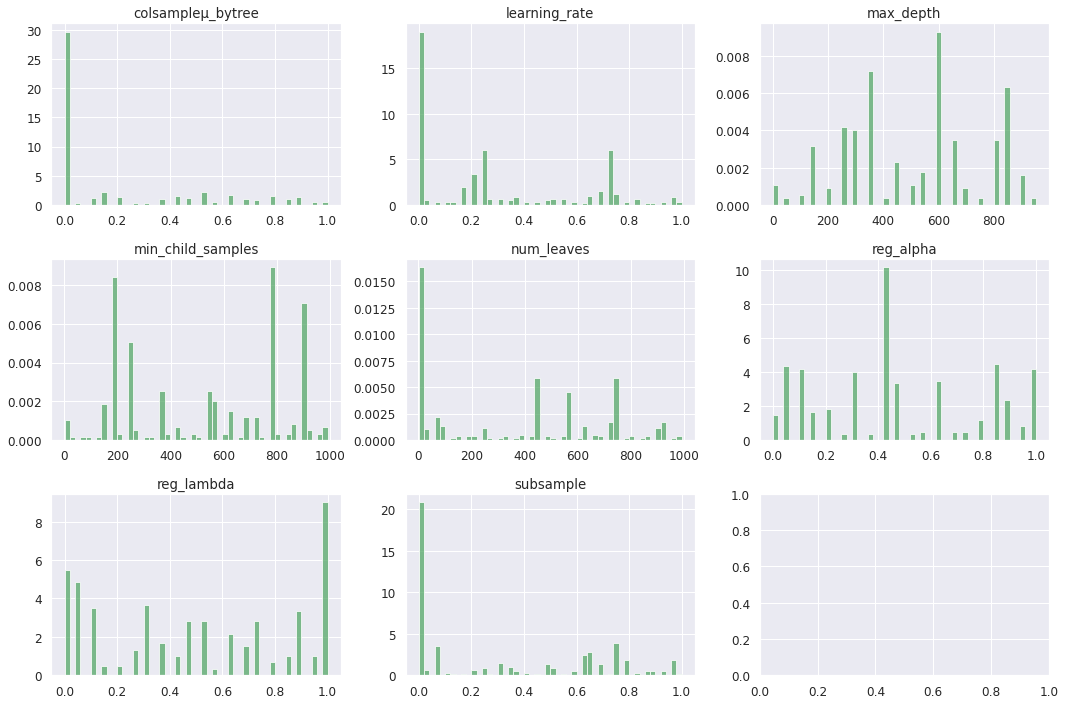

In [48]:

x_line = [np.around(np.linspace(0, 1, 20),3), np.around(np.linspace(0, 1, 30), 3), np.arange(1, 1000, 50),
 np.arange(1, 1000, 30), np.arange(1, 1000, 30), np.around(np.linspace(0, 1, 20),3),
 np.around(np.linspace(0, 1, 20), 3), np.around(np.linspace(0, 1, 30),3)]


parameters = ['colsampleµ_bytree', 'learning_rate', 'max_depth', 'min_child_samples', 'num_leaves', 'reg_alpha',
             'reg_lambda', 'subsample']
f, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print(i, val)
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    k=0
    xss = []
    for j in xs:
        xss.append(x_line[i][j])
        k +=1
    #axes[int(i/3),i%3].catplot(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=cmap(float(i)/len(parameters)))
    axes[int(i/3),i%3].hist(xss, 50, density=1, facecolor='g', alpha=0.75)
    axes[int(i/3),i%3].set_title(val)
    #axes[i/3,i%3].set_ylim([0.9,1.0])
plt.tight_layout()

## MODELISATION LGBM

**Avec nos espaces de recherche trouvés nous lançons une gridsearch**

In [21]:
params = {'class_weight': [None],
          'colsample_bytree': np.linspace(0, 0.1, 5),
          'learning_rate': np.linspace(0, 0.3, 10),
          'max_depth': np.arange(500, 700, 10),
          'min_child_samples': np.arange(750, 950, 10),
          'num_leaves': np.arange(0, 150, 10),
          'reg_alpha': np.linspace(0.4, 0.5, 10),
          'reg_lambda': np.linspace(0.9, 1, 10),
          'subsample': np.linspace(0, 0.1, 10)
         }


In [68]:


test_weight = [2.5, 2.75, 3, 3.25, 3.5, 3.75, 4]
threshold = np.linspace(0,1, 101)

score_l = np.ndarray((101, 7))
m = 1

for i in test_weight:
    
    weight_f1 = i
    LGBM = LGBMClassifier(metric="custom")
    lgbm_random = RandomizedSearchCV(estimator = LGBM, param_distributions = params, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True), n_iter = 200, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
    lgbm_random.fit(x_reduced, y_reduced)
    proba_train = lgbm_random.predict_proba(x_train)
    pred_test = lgbm_random.predict_proba(x_test)
    
    best_score = [0, 0] 
    k = 0
    
    for j in threshold: 
        pred_train = np.where(proba_train[:,1]>j,1,0)
        score_l[k,0] = j
        score_l[k,m] = evaluate_macroF1direct_lgb(y_train, pred_train)
        if score_l[k,m] > best_score[1]:
            best_score[0] = score_l[k,0]
            best_score[1] = score_l[k,m]
        k += 1
    
    pred_test = lgbm_random.predict_proba(x_test)
    pred_train = np.where(proba_train[:,1]>best_score[0],1,0)
    pred_test = np.where(pred_test[:,1]>best_score[0],1,0)
    
    TN, FP, FN, TP = confusion_matrix(y_train, pred_train).ravel()
    specificity_train = TN / (TN + FP)
    TN, FP, FN, TP = confusion_matrix(y_test, pred_test).ravel()
    specificity_test = TN / (TN + FP)
    
    print("\n\nTEST poids :", i, "Threshold : ", best_score[0], "\n",
         "-------------------\n",
          "ROC_AUC_pondéré : " + str(best_score[1]),
         "\n-------------------\n",
         "Recall score train : " + str(recall_score(y_train, pred_train)), "\n",
         "Recall score test : " + str(recall_score(y_test, pred_test)), "\n",
         "-------------------\n",
         "Specificity score train : " + str(specificity_train) + "\n",
         "Specificity score test : " + str(specificity_test) + "\n")
    
    m += 1

score_l = pd.DataFrame(score_l, columns = ['Threshold', 'weight_100', 'weight_125', 'weight_150', 'weight_200', 'weight_500', 'weight_1000'])

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 2.5 Threshold :  0.32 
 -------------------
 ROC_AUC_pondéré : 0.533325186292509 
-------------------
 Recall score train : 0.7785129932627527 
 Recall score test : 0.6910132910620655 
 -------------------
 Specificity score train : 0.6880160925851618
 Specificity score test : 0.6799498263218834

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 2.75 Threshold :  0.29 
 -------------------
 ROC_AUC_pondéré : 0.5574388869396366 
-------------------
 Recall score train : 0.8147858517805582 
 Recall score test : 0.7446652847213754 
 -------------------
 Specificity score train : 0.636792253595489
 Specificity score test : 0.6287147819374759

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


TEST poids : 3 Threshold :  0.27 
 -------------------
 ROC_AUC_pondéré : 0.5814741669316642 
-------------------
 Recall score train : 0.8359600577478344 
 Recall score test : 0.

KeyboardInterrupt: 

**Suite aux différentes itérations nous gardons comme poids 3.0, avec un seuil de 0.27**

In [22]:
weight_f1 = 3.0
threshold = 0.27
LGBM = LGBMClassifier(metric="custom")
lgbm_random = RandomizedSearchCV(estimator = LGBM, param_distributions = params, scoring=make_scorer(evaluate_macroF1_lgb_cv, greater_is_better=True), n_iter = 200, cv = 5, verbose=150, random_state=42, n_jobs = -1)# Fit the random search model 
lgbm_random.fit(x_reduced, y_reduced)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5, estimator=LGBMClassifier(metric='custom'), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'class_weight': [None],
                                        'colsample_bytree': array([0.   , 0.025, 0.05 , 0.075, 0.1  ]),
                                        'learning_rate': array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ]),
                                        'max_depth': array([500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600...
       0.45555556, 0.46666667, 0.47777778, 0.48888889, 0.5       ]),
                                        'reg_lambda': array([0.9       , 0.91111111, 0.92222222, 0.93333333, 0.94444444,
       0.95555556, 0.96666667, 0.97777778, 0.98888889, 1.        ]),
                                        'subsample': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.

In [23]:
pred_train = lgbm_random.predict_proba(x_train)
pred_test = lgbm_random.predict_proba(x_test)
pred_train = np.where(pred_train[:,1]>threshold,1,0)
pred_test = np.where(pred_test[:,1]>threshold,1,0)

In [24]:
filename = 'Streamlit/LightGBMModel.json' 
outfile = open(filename,'wb') 
joblib.dump(lgbm_random.best_estimator_, outfile) 
outfile.close()

In [148]:
lgbm_random.best_params_

{'subsample': 0.08888888888888889,
 'reg_lambda': 0.9111111111111111,
 'reg_alpha': 0.4,
 'num_leaves': 90,
 'min_child_samples': 760,
 'max_depth': 690,
 'learning_rate': 0.3,
 'colsample_bytree': 0.1,
 'class_weight': None}

In [149]:
lgbm_random.best_score_

0.4484049595228856

In [150]:
print("Recall score train : " + str(recall_score(y_train, pred_train)))
print("Recall score test : " + str(recall_score(y_test, pred_test)))

Recall score train : 0.8519008662175168
Recall score test : 0.7673454456773564


In [151]:
print("Accuracy score train : " + str(accuracy_score(y_train, pred_train)))
print("Accuracy score test : " + str(accuracy_score(y_test, pred_test)))

Accuracy score train : 0.6277010891723455
Accuracy score test : 0.6129861939158627


## COURBE ROC-AUC ET MATRICE DE CONFUSION

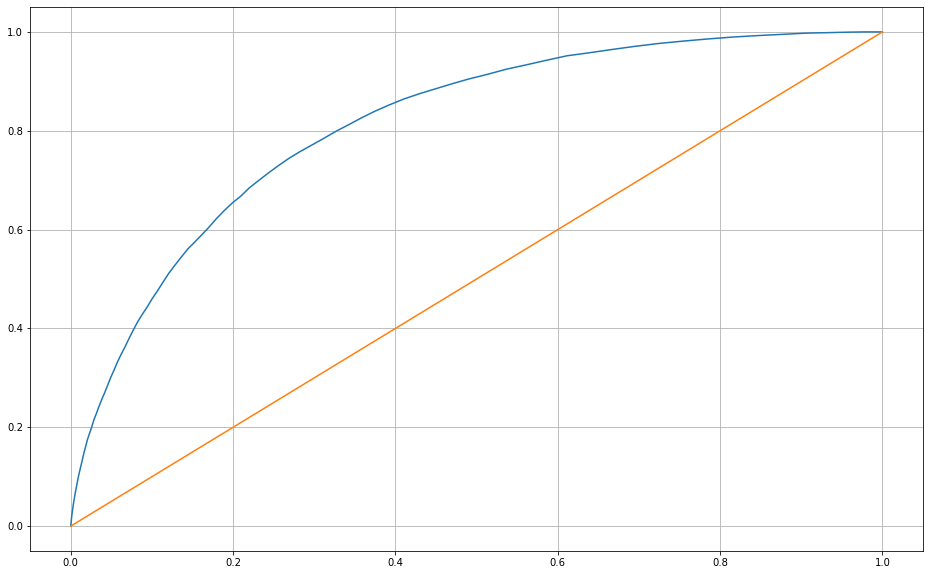

In [152]:
auc_roc = np.ndarray((101, 3), 'float16')
j = 0

for i in np.linspace(0, 1, 101):
    
    predictions = lgbm_random.predict_proba(x_train)[:,1]
    truth = y_train
    mask = truth ==1
    pred_labels = np.where(predictions < i, 0, 1)
    TP = np.count_nonzero((truth + pred_labels) == 2, axis=0)
    FN = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    mask = truth ==0
    TN = np.count_nonzero((truth + pred_labels)[mask] == 0, axis=0)
    FP = np.count_nonzero((truth + pred_labels)[mask] == 1, axis=0)
    
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    FPR = 1 - specificity
    auc_roc[j, 0] = recall
    auc_roc[j, 1] = FPR
    auc_roc[j, 2] = i
    j +=1

plt.figure(figsize=(16,10))
plt.plot(auc_roc[:, 1], auc_roc[:, 0])
plt.plot([0,1], [0,1])
plt.grid(True)
plt.show()

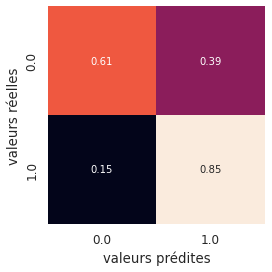

In [58]:
conf = confusion_matrix(y_train, pred_train, normalize='true')


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

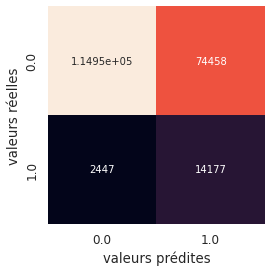

In [59]:
conf = confusion_matrix(y_train, pred_train)


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()), fmt = '.5g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

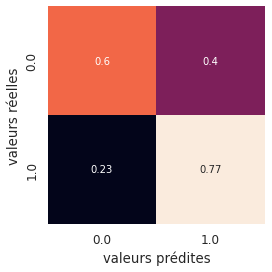

In [63]:
conf = confusion_matrix(y_test, pred_test, normalize='true')


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()))
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

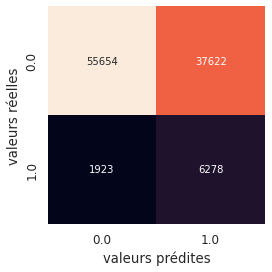

In [65]:
conf = confusion_matrix(y_test, pred_test)


sns.heatmap(conf, square=True, annot=True, cbar=False
            , xticklabels=list(y_train.unique())
            , yticklabels=list(y_train.unique()), fmt = '.5g')
plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')
plt.show()

## FEATURES IMPORTANCE

In [25]:
shap.initjs()

In [26]:
data = shap.sample(x_test, 1000)

explainer = shap.TreeExplainer(lgbm_random.best_estimator_,model_output="raw", feature_perturbation="tree_path_dependent")

shap_values = explainer.shap_values(data)
#explainer = shap.TreeExplainer(lgbm_random.best_estimator_)

#shap_values = explainer(shap.sample(x_reduced, 1000))

shap_interaction_values = explainer.shap_interaction_values(data)

background_display = x_test.copy()
background_display[mask_categ] = scaler_x.inverse_transform(x_test[mask_categ])
background_display = background_display.loc[data.index]

In [27]:
class helper_object():
    """
    This wraps the shap object.
    It takes as input i, which indicates the index of the observation to be explained.
    """
    def __init__(self, i):
        self.base_values = shap_values.base_values[i][0]
        self.data = data.loc[i]
        self.feature_names = data.columns.to_list()
        self.values = shap_values.values[i]

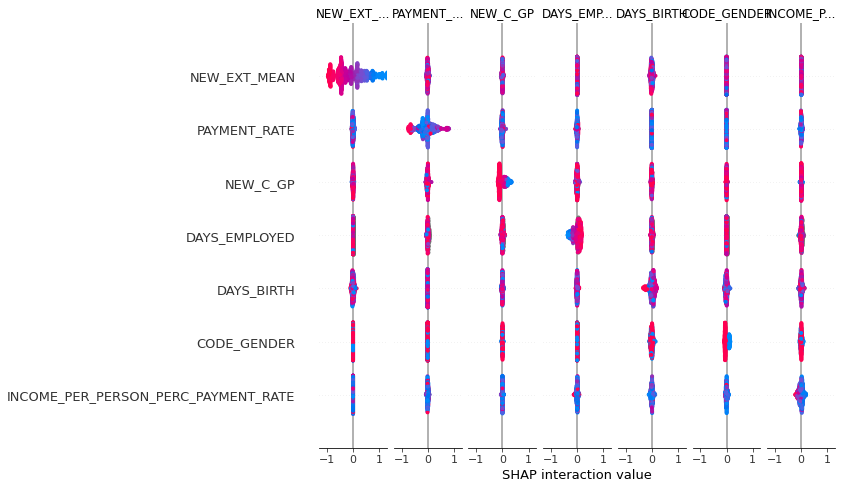

In [28]:
shap.summary_plot(shap_interaction_values, data, plot_type = 'bar')

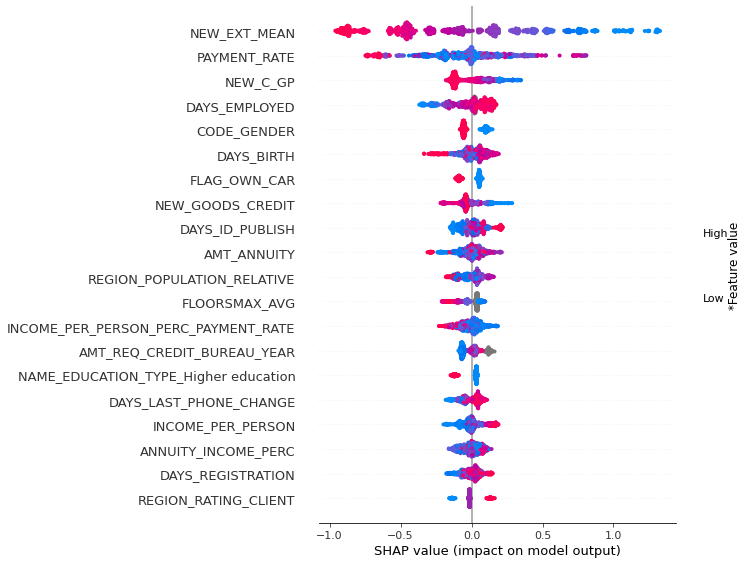

In [29]:
shap.summary_plot(shap_interaction_values, data, plot_type="compact_dot")

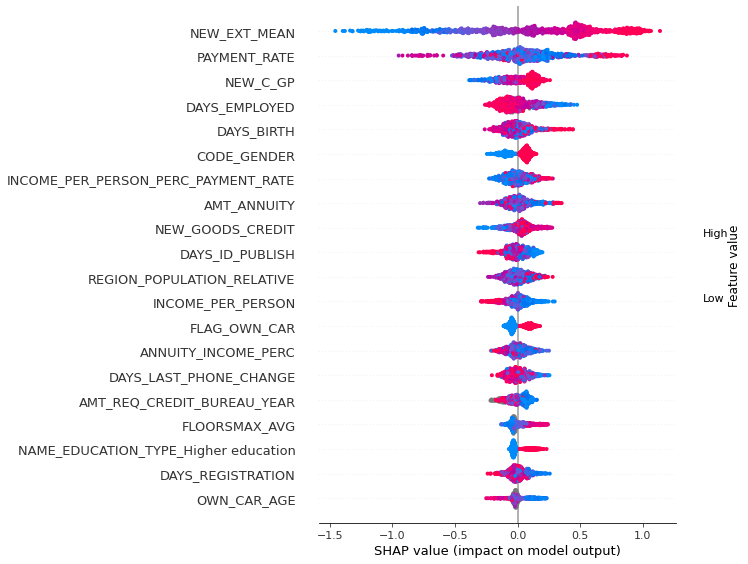

In [32]:
shap.summary_plot(shap_values[0], data)

In [35]:
explainer = shap.TreeExplainer(lgbm_random.best_estimator_, feature_perturbation='interventional')

shap_values = explainer.shap_values(data)
#explainer = shap.TreeExplainer(lgbm_random.best_estimator_)

#shap_values = explainer(shap.sample(x_reduced, 1000))

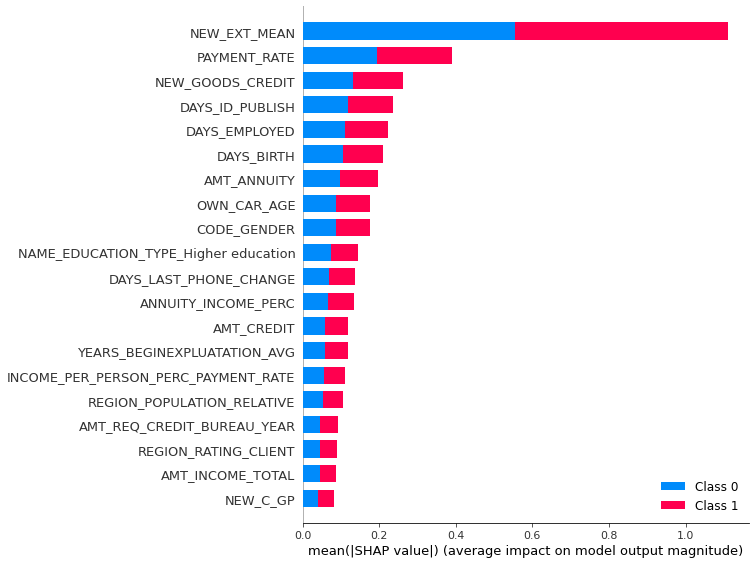

In [99]:
shap.summary_plot(shap_values, feature_names=x_test.columns)

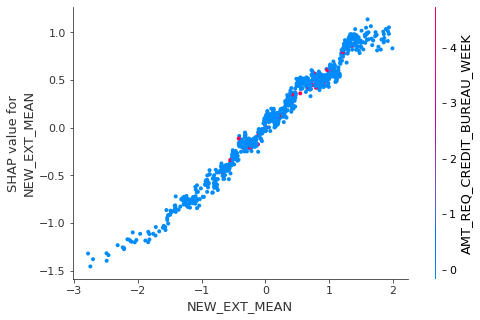

In [37]:
shap.dependence_plot("NEW_EXT_MEAN", shap_values[0], data)

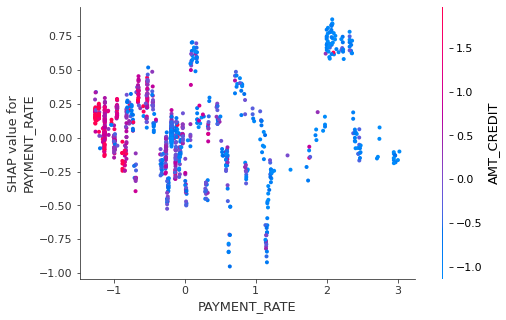

In [33]:
shap.dependence_plot("PAYMENT_RATE", shap_values[0], data)

In [36]:
shap.plots.force(explainer.expected_value[0], shap_values[0][300],background_display.iloc[300], feature_names = x_train.columns)

In [83]:
x_train.head()

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
SK_ID_CURR                                                                   
259905                       0            0             1                0   
319650                       0            1             0                1   
137317                       0            0             0                0   
449557                       0            0             0                0   
346718                       0            0             1                0   

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
259905             -0.59              0.35       -0.75        -0.22   
319650             -0.59             -0.98       -0.17        -0.13   
137317             -0.59             -0.57       -0.77        -0.91   
449557             -0.59              0.57       -0.11         0.91   
346718             -0.59              2.75        3.03         1.77   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
259905                           -0.98        0.07           0.51   
319650                           -0.12       -1.75            NaN   
137317                           -1.24       -1.39            NaN   
449557                            1.16       -0.15           0.16   
346718                           -1.06       -0.31           0.54   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  CNT_FAM_MEMBERS  \
SK_ID_CURR                                                                     
259905                   0.38            -0.72        -0.37            -1.26   
319650                  -0.55            -0.76          NaN            -0.17   
137317                   0.97            -0.82          NaN            -0.17   
449557                   1.37             0.38          NaN            -0.17   
346718                   0.26             1.60         0.72            -0.17   

            REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  APARTMENTS_AVG  \
SK_ID_CURR                                                                  
259905                     -0.16                     1.53            1.68   
319650                     -0.16                    -1.22             NaN   
137317                     -0.16                    -0.61             NaN   
449557                     -0.16                     0.00             NaN   
346718                      1.80                    -1.52           -0.49   

            BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  COMMONAREA_AVG  \
SK_ID_CURR                                                                  
259905                  2.04                         0.08            0.38   
319650                   NaN                          NaN             NaN   
137317                   NaN                          NaN             NaN   
449557                   NaN                          NaN             NaN   
346718                 -0.33                         0.02           -0.22   

            ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
SK_ID_CURR                                                               
259905               1.84           1.27           0.78           0.93   
319650                NaN            NaN            NaN            NaN   
137317                NaN            NaN            NaN            NaN   
449557                NaN            NaN            NaN            NaN   
346718              -0.57          -0.44          -0.37          -0.12   

            LANDAREA_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
SK_ID_CURR                                                          
259905              0.55            1.94                    -0.19   
319650               NaN             NaN                      NaN   
137317               NaN             NaN       

In [93]:
xx_train = x_train.fillna(x_train.mean()).to_numpy()
xx_test = x_test.fillna(x_train.mean()).to_numpy()

explainer = lime_tabular.LimeTabularExplainer(x_train.to_numpy(), mode="classification",
                                              feature_names=x.columns, discretize_continuous=False)

explainer

In [94]:

idx = random.randint(1, len(xx_test))

#print("Prediction : ", df_train.TARGET[lgbm_random.predict(xx_test[idx].reshape(1,-1))[0]])
#print("Actual :     ", df_train.TARGET[y_test[idx]])

explanation = explainer.explain_instance(xx_test[idx], lgbm_random.predict_proba,
                                         num_features=len(x_train.columns))

explanation.show_in_notebook()

In [103]:
preds = lgbm_random.predict(xx_test)

false_preds = np.argwhere(preds != y_test.to_numpy).flatten()

idx  = random.choice(false_preds)

#print("Prediction : ", breast_cancer.target_names[lr.predict(X_test[idx].reshape(1,-1))[0]])
#print("Actual :     ", breast_cancer.target_names[Y_test[idx]])

explanation = explainer.explain_instance(xx_test[idx], lgbm_random.predict_proba)

explanation.show_in_notebook()

**En interprétation globale : Le modèle est vraiment dirigé par la variable New_EXT_MEAN**

**En interprétation locale : On a le même constat, cette variable intéragit peu avec les autres, on dirait même qu'elle est la moyenne de toutes les autres tellement elle dirige les prédictions**

## ADAPTATION POUR DASHBOARD

**Nous adaptons le dataframe qui servira à afficher les informations sur le dashboard en le rendant plus lisible pour un non data scientiste et nous réduisons la taille des données à 100 individus pour éviter de surcharger le serveur**

In [38]:
raw_data = import_data_binary()
raw_data = raw_data.drop('TARGET', axis=1)
raw_scaled = raw_data.drop(col_corr, axis = 1).copy()
raw_scaled[mask_categ] = scaler_x.transform(raw_scaled[mask_categ])

Memory usage of dataframe is 103.62 MB
Memory usage after optimization is: 181.08 MB
Decreased by -74.8%


In [39]:
raw_scaled = raw_scaled.sample(n=100, random_state=101)
sample_index = raw_scaled.index
raw_data = raw_data.loc[sample_index,:]

In [41]:
raw_scaled.to_csv("Streamlit/DATA_SCALED.csv")

In [43]:
raw_data.columns = ['Type_credit',
 'Genre',
 'Voiture',
 'Proprietaire',
 'Enfants',
 'Revenus',
 'Montant_credit',
 'Cout_annuel_credit',
 'Valeur_bien_finance',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'Anciennete_emploi_actuel',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'Taille_foyer',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'REGION',
 'NAME_TYPE_SUITE_Children',
 'NAME_TYPE_SUITE_Family',
 'NAME_TYPE_SUITE_Rare',
 'NAME_TYPE_SUITE_Spouse_ partner',
 'NAME_TYPE_SUITE_Unaccompanied',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Rare',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Working',
 'Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special',
 'PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve',
 'OCCUPATION_TYPE_Accountants',
 'OCCUPATION_TYPE_Core staff',
 'OCCUPATION_TYPE_Drivers',
 'OCCUPATION_TYPE_HR staff',
 'OCCUPATION_TYPE_High skill tech staff',
 'OCCUPATION_TYPE_Laborers',
 'OCCUPATION_TYPE_Low_skill Laborers',
 'OCCUPATION_TYPE_Managers',
 'OCCUPATION_TYPE_Medicine staff',
 'OCCUPATION_TYPE_Realty agents',
 'OCCUPATION_TYPE_Sales staff',
 'OCCUPATION_TYPE_Secretaries',
 'ORGANIZATION_TYPE_Agriculture',
 'ORGANIZATION_TYPE_Business Entity',
 'ORGANIZATION_TYPE_Construction',
 'ORGANIZATION_TYPE_Education',
 'ORGANIZATION_TYPE_Finance',
 'ORGANIZATION_TYPE_Government',
 'ORGANIZATION_TYPE_HotelRestaurant',
 'ORGANIZATION_TYPE_House',
 'ORGANIZATION_TYPE_Industry',
 'ORGANIZATION_TYPE_Other',
 'ORGANIZATION_TYPE_Public',
 'ORGANIZATION_TYPE_Security',
 'ORGANIZATION_TYPE_Self_employed',
 'ORGANIZATION_TYPE_Services',
 'ORGANIZATION_TYPE_Trade',
 'ORGANIZATION_TYPE_Transport',
 'ORGANIZATION_TYPE_XNA',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'Annuite/revenus',
 'PAYMENT_RATE',
 'NEW_EXT_MEAN',
 'NEW_APP_EXT_SOURCES_PROD',
 'NEW_GOODS_CREDIT',
 'NEW_C_GP',
 'Age',
 'NEW_LOAN_VALUE_RATIO',
 'INCOME_PER_PERSON_PERC_PAYMENT_RATE']

mask = ['Type_credit',
 'Genre',
 'Voiture',
 'Proprietaire',
 'Enfants',
 'Revenus',
 'Montant_credit',
 'Cout_annuel_credit',
 'Valeur_bien_finance',
 'Anciennete_emploi_actuel',
 'Taille_foyer',
 'Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special',
 'PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve',
 'Annuite/revenus',
 'Age']

raw_data = raw_data.loc[:, mask] 
del mask

In [44]:
raw_data.columns

Index(['Type_credit', 'Genre', 'Voiture', 'Proprietaire', 'Enfants', 'Revenus',
       'Montant_credit', 'Cout_annuel_credit', 'Valeur_bien_finance',
       'Anciennete_emploi_actuel', 'Taille_foyer', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Secondary _ secondary special',
       'PACS', 'Marrie', 'Separe', 'Celibataire', 'Inconnu', 'veuf_veuve',
       'Annuite/revenus', 'Age'],
      dtype='object')

In [45]:
raw_data['Education'] = reverse_one_hot_encoding(raw_data.loc[:, ['Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special']])
raw_data = raw_data.drop(['Higher education',
 'Incomplete higher',
 'Lower secondary',
 'Secondary _ secondary special'] ,axis=1)

raw_data['Statut_Marital'] = reverse_one_hot_encoding(raw_data.loc[:, ['PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve']])
raw_data = raw_data.drop(['PACS',
 'Marrie',
 'Separe',
 'Celibataire',
 'Inconnu',
 'veuf_veuve'] ,axis=1)

tempo_list = [['revolving', 'cash_credit'],
['homme', 'femme'],
[True, False],
[True, False]]

for i in range(0, 4, 1):
    raw_data[raw_data.columns[i]] = raw_data[raw_data.columns[i]].apply(lambda x: np.where(x, tempo_list[i][0], tempo_list[i][1]))

del tempo_list 


raw_data["Anciennete_emploi_actuel"] = raw_data["Anciennete_emploi_actuel"].apply(lambda x: anciennete(x))

In [46]:
raw_data.to_csv("Streamlit/DATA.csv")